## Predicting energy consumption based on location

In [7]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error


In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


## Connecting to the database

In [9]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="...",
    database="...",
    user="...",
    password="..."
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM station_data_hour"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())


   location_id location_friendlyname location_friendlycode  \
0       168298          Nadin Sjever           HRHEP-23004   
1       168298          Nadin Sjever           HRHEP-23004   
2       168298          Nadin Sjever           HRHEP-23004   
3       168298          Nadin Sjever           HRHEP-23004   
4       168298          Nadin Sjever           HRHEP-23004   

  location_address_cityname  location_address_postnumber  \
0                  Benkovac                        23420   
1                  Benkovac                        23420   
2                  Benkovac                        23420   
3                  Benkovac                        23420   
4                  Benkovac                        23420   

  location_address_streetname location_address_housenumber  \
0                       Nadin                           bb   
1                       Nadin                           bb   
2                       Nadin                           bb   
3                 

In [10]:
# Provide the dataframe from database
data_stations = df.copy()

In [11]:
len(data_stations['location_friendlyname'].unique())

257

In [12]:
# dropping the unnecessary columns
data_stations.drop(columns=['location_friendlycode',
                                           'location_address_cityname',
                                          'location_address_postnumber',
                                          'location_address_streetname',
                                          'location_address_housenumber'], axis=1, inplace=True)
data_stations

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
0,168298,Nadin Sjever,Public access - Free access,2021-10-01 07:00:00+00:00,15.416667,4,0,28.403340,37
1,168298,Nadin Sjever,Public access - Free access,2021-10-01 08:00:00+00:00,15.416667,4,0,28.403340,37
2,168298,Nadin Sjever,Public access - Free access,2021-10-01 10:00:00+00:00,4.583333,4,0,7.812776,11
3,168298,Nadin Sjever,Public access - Free access,2021-10-01 17:00:00+00:00,1.666667,4,0,2.671887,4
4,168298,Nadin Sjever,Public access - Free access,2021-10-01 18:00:00+00:00,15.833333,4,0,25.382931,38
...,...,...,...,...,...,...,...,...,...
435210,168298,Nadin Sjever,Public access - Free access,2021-09-28 17:00:00+00:00,5.833333,4,0,10.854399,14
435211,168298,Nadin Sjever,Public access - Free access,2021-09-29 09:00:00+00:00,23.750000,4,0,41.241983,57
435212,168298,Nadin Sjever,Public access - Free access,2021-09-29 10:00:00+00:00,2.083333,4,0,3.617718,5
435213,168298,Nadin Sjever,Public access - Free access,2021-09-30 12:00:00+00:00,18.750000,4,0,36.944325,45


### Expand data and plot measurements

In [13]:
def expand_data(dataframe):
    # function that expands original dataframe with all time stamps
    '''inputs: original dataframe with values for ONE station'''
    
    dataframe_copy = dataframe.copy()
    dataframe_sorted = dataframe_copy.sort_values('location_friendlyname')
    dataframe_sorted['Time'] = pd.to_datetime(dataframe_sorted['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
    list_names = dataframe_sorted['location_friendlyname'].unique()
    indices_all = []
    dfs = []
    
    for name in list_names:
        dataframe_slice = dataframe_sorted.loc[dataframe_copy['location_friendlyname'] == str(name)].copy().reset_index(drop=True)

        # create new dataframe with index as every hour        
        start_index = dataframe_slice['Time'].min() #starting point is the day of the first index
        end_index = dataframe_slice['Time'].max() # ending pojnt is the day of the last index
        indices = pd.date_range(start_index, end_index, freq='1H')
        indices_all.extend(indices)
        
        dataframe_slice.set_index('Time', inplace=True)
        new_dataframe = pd.DataFrame(index=indices, data=dataframe_slice)

        new_dataframe['Time'] = new_dataframe.index
        new_dataframe['location_id'] = new_dataframe['location_id'].fillna(dataframe_slice['location_id'][0])
        new_dataframe['location_friendlyname'] = new_dataframe['location_friendlyname'].fillna(dataframe_slice['location_friendlyname'][0])
        new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_slice['location_accesstype_title'][0])
        new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan) 
        # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
        
        new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
        new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_slice['connector_count'][0])
        new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
        new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
        new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)
        dfs.append(new_dataframe)
        
    dataframe_total_exp = pd.concat(dfs, ignore_index=True)
    
    return dataframe_total_exp
    
    
    

In [14]:
expanded_data_all = expand_data(data_stations)
expanded_data_all

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,120929.0,Antunovac,Public access - Free access,2021-06-30 13:00:00+00:00,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 13:00:00
1,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 14:00:00
2,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 15:00:00
3,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 16:00:00
4,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2021-06-30 17:00:00
...,...,...,...,...,...,...,...,...,...,...
3803007,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 17:00:00
3803008,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 18:00:00
3803009,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 19:00:00
3803010,238019.0,Žminj,Public access - Free access,2022-10-16 20:00:00+00:00,10.000000,2.0,0.0,0.021541,12.0,2022-10-16 20:00:00


In [15]:
expanded_data_all['location_id'].unique() # the list of selected stations (among those 30k rows of data)

array([120929., 141864., 230066., 230065., 229795., 171102., 173557.,
       171114., 205060., 262383., 129447., 129448., 171103., 120965.,
       140628., 205054., 161999., 120962., 120983., 238018., 205055.,
       163237., 120951., 154567., 238031., 180425., 120956., 120957.,
       180424., 216794., 120943., 170046., 234850., 120982., 171020.,
       189996., 129451., 120953., 171110., 205057., 162004., 162003.,
       234817., 180427., 205049., 215491., 230067., 230068., 120944.,
       205056., 133236., 171017., 230074., 264960., 129449., 171111.,
       162000., 215493., 230069., 238020., 120979., 120978., 107579.,
       120976., 171119., 171118., 120972., 189985., 215489., 210272.,
       171126., 120973., 171019., 216796., 120955., 120964., 205052.,
       129454., 120971., 230081., 200692., 129445., 129446., 120969.,
       120967., 161820., 162002., 162001., 140629., 256616., 205066.,
       189989., 120959., 234849., 216795., 161997., 168299., 168298.,
       120926., 1630

In [16]:
data_stations.sort_values('location_friendlyname')

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
228646,120929,Antunovac,Public access - Free access,2022-02-25 10:00:00+00:00,50.000000,2,1,2.502812,60
228582,120929,Antunovac,Public access - Free access,2022-01-27 11:00:00+00:00,50.000000,2,1,1.789296,60
228583,120929,Antunovac,Public access - Free access,2022-01-27 12:00:00+00:00,50.000000,2,1,1.789296,60
228584,120929,Antunovac,Public access - Free access,2022-01-27 13:00:00+00:00,48.333333,2,0,1.729653,58
228585,120929,Antunovac,Public access - Free access,2022-01-31 08:00:00+00:00,42.500000,2,0,0.765214,51
...,...,...,...,...,...,...,...,...,...
198420,238019,Žminj,Public access - Free access,2022-08-09 18:00:00+00:00,45.000000,2,0,14.152692,54
198421,238019,Žminj,Public access - Free access,2022-08-10 19:00:00+00:00,9.166667,2,0,1.257661,11
198422,238019,Žminj,Public access - Free access,2022-08-11 11:00:00+00:00,36.666667,2,0,12.666152,44
198414,238019,Žminj,Public access - Free access,2022-08-08 12:00:00+00:00,15.833333,2,0,5.405549,19


In [17]:
def create_data_plots(dataframe, name):
    '''input is expanded dataframe and selected name for one location'''
        
    # Get the data from the wanted columns - energy consumption and utilization
    dataframe_slice = dataframe.loc[dataframe['location_friendlyname']==str(name)]
    cons_column_data1 = dataframe_slice['energy_consumption']
    util_column_data1 = dataframe_slice['utilization']
    time = dataframe_slice['Time']
    
    fig, ax1 = plt.subplots(figsize=(20, 12))

    ax2 = ax1.twinx()
    ax1.plot(time, util_column_data1, 'crimson')
    ax2.plot(time, cons_column_data1, 'teal')

    ax1.set_xlabel('Timesteps', fontsize=20)
    ax1.set_ylabel('Utilization', color='crimson', fontsize=20)
    ax2.set_ylabel('Consumption', color='teal', fontsize=20)
    plt.title('Values of energy consumption and utilization, ' + str(name), fontsize=20)
    # plt.savefig('Mjerenja output Opatija.png')
    plt.show()
    
    

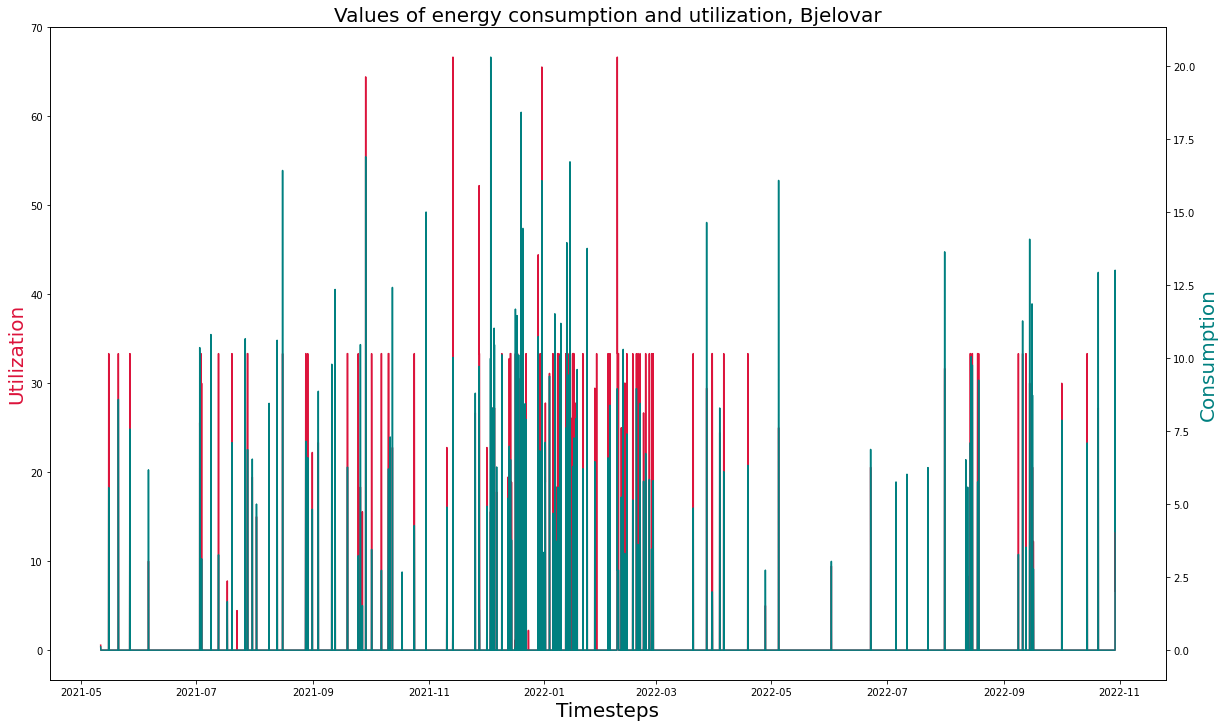

In [18]:
create_data_plots(expanded_data_all, 'Bjelovar')

### Data preparation

In [19]:
filter_data = expanded_data_all.copy() # here we selected all stations 


In [20]:
# here 70% of data for each station is selected as train data, 10% is validation/test/real set
# with this we ensure that each station has enough data to be trained on

train_data_2 = []
val_data_2 = []
test_data_2 = []
real_data_2 = []

for name in list(filter_data['location_friendlyname'].unique()):
    filtered_pom = filter_data.loc[filter_data['location_friendlyname'] == str(name)]
    train_size = int(0.7 * len(filtered_pom))
    val_size = int(0.1 * len(filtered_pom))
    train_data_2.append(filtered_pom.iloc[:train_size])
    val_data_2.append(filtered_pom.iloc[train_size:train_size + val_size])
    test_data_2.append(filtered_pom.iloc[train_size + val_size:train_size + val_size+val_size])
    real_data_2.append(filtered_pom.iloc[train_size + val_size+val_size:])
    
train_data = pd.concat(train_data_2, ignore_index = True)
val_data = pd.concat(val_data_2, ignore_index = True)
test_data = pd.concat(test_data_2, ignore_index = True)
real_data = pd.concat(real_data_2, ignore_index = True)

In [21]:
filter_data.loc[filter_data['location_id']==170046]

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
464431,170046.0,EurokodTEST,Public access but not visible to public,2020-09-22 09:00:00+00:00,12.083333,4.0,0.0,3.403808,29.0,2020-09-22 09:00:00
464432,170046.0,EurokodTEST,Public access but not visible to public,2020-09-22 10:00:00+00:00,2.500000,4.0,0.0,0.704236,6.0,2020-09-22 10:00:00
464433,170046.0,EurokodTEST,Public access but not visible to public,NaT,0.000000,4.0,0.0,0.000000,0.0,2020-09-22 11:00:00
464434,170046.0,EurokodTEST,Public access but not visible to public,NaT,0.000000,4.0,0.0,0.000000,0.0,2020-09-22 12:00:00
464435,170046.0,EurokodTEST,Public access but not visible to public,NaT,0.000000,4.0,0.0,0.000000,0.0,2020-09-22 13:00:00
...,...,...,...,...,...,...,...,...,...,...
473025,170046.0,EurokodTEST,Public access but not visible to public,NaT,0.000000,4.0,0.0,0.000000,0.0,2021-09-15 11:00:00
473026,170046.0,EurokodTEST,Public access but not visible to public,2021-09-15 12:00:00+00:00,22.916667,4.0,0.0,5.301423,55.0,2021-09-15 12:00:00
473027,170046.0,EurokodTEST,Public access but not visible to public,2021-09-15 13:00:00+00:00,25.000000,4.0,1.0,5.783370,60.0,2021-09-15 13:00:00
473028,170046.0,EurokodTEST,Public access but not visible to public,2021-09-15 14:00:00+00:00,25.000000,4.0,1.0,5.783370,60.0,2021-09-15 14:00:00


In [22]:
train_data

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,120929.0,Antunovac,Public access - Free access,2021-06-30 13:00:00+00:00,0.0,2.0,0.0,0.0,0.0,2021-06-30 13:00:00
1,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 14:00:00
2,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 15:00:00
3,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 16:00:00
4,120929.0,Antunovac,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2021-06-30 17:00:00
...,...,...,...,...,...,...,...,...,...,...
2661983,238019.0,Žminj,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2022-07-30 14:00:00
2661984,238019.0,Žminj,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2022-07-30 15:00:00
2661985,238019.0,Žminj,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2022-07-30 16:00:00
2661986,238019.0,Žminj,Public access - Free access,NaT,0.0,2.0,0.0,0.0,0.0,2022-07-30 17:00:00


In [23]:
len(train_data['location_friendlyname'].unique())

257

In [24]:
len(val_data['location_friendlyname'].unique())

256

In [25]:
total_id_locations = list(filter_data['location_id'].unique())
len(total_id_locations)

257

In [26]:
data_stations.loc[data_stations['location_friendlyname']=='Čazma']

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
6867,171101,Čazma,Public access - Free access,2021-06-01 14:00:00+00:00,11.666667,2,0,0.000000,14
6868,171101,Čazma,Public access - Free access,2021-06-07 14:00:00+00:00,11.666667,2,0,2.735658,14
6869,171101,Čazma,Public access - Free access,2021-06-09 07:00:00+00:00,29.166667,2,0,9.862186,35
6870,171101,Čazma,Public access - Free access,2021-06-09 08:00:00+00:00,50.000000,2,1,16.906604,60
6871,171101,Čazma,Public access - Free access,2021-06-09 09:00:00+00:00,26.666667,2,0,9.016855,32
...,...,...,...,...,...,...,...,...,...
7146,171101,Čazma,Public access - Free access,2022-06-04 15:00:00+00:00,50.000000,2,1,10.617686,60
7147,171101,Čazma,Public access - Free access,2022-06-04 16:00:00+00:00,50.000000,2,1,10.617686,60
7148,171101,Čazma,Public access - Free access,2022-06-04 17:00:00+00:00,15.833333,2,0,3.362267,19
7149,171101,Čazma,Public access - Free access,2022-06-18 17:00:00+00:00,23.333333,2,0,3.397354,28


In [88]:
# here dataset is transformed - new features are added and unnecessary features are removed
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, all_loc_id):
        
        # Extract year, month, and day from the timestamp
        dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
        dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
        dataframe['Day'] = pd.DatetimeIndex(dataframe['Time']).dayofweek
        
        # Convert year to the number of years since 1970
        dataframe['Year'] = dataframe['Year'] - 1970
                
        # One-hot encode the month
        dataframe = pd.get_dummies(dataframe, columns=['Month'])
        
        num_months = (dataframe.filter(regex='Month_')).shape[-1]
        
        # if there are less than 12 months in dataset (for example, if training dataset consists of only 9 months)
        # this if condition adds columns for all the months - in case there are missing months, these columns are filled with zeros
        if num_months < 12:
            list_existing_months = dataframe.filter(regex='Month_').columns
            list_all_months = [f'Month_{i}' for i in range(1, 13)]
            list_non_existing_months = [x for x in list_all_months if x not in list_existing_months]
            for i in list_non_existing_months:
                dataframe[i] = 0
            
        # print(dataframe)
        
        # Transform day of the week into the corresponding weekday
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dataframe['Day'] = dataframe['Day'].apply(lambda x: weekdays[x])
        
        # One-hot encode the day
        dataframe = pd.get_dummies(dataframe, columns=['Day'])
        num_days = (dataframe.filter(regex='Day_')).shape[-1]
        if num_days < 7:
            list_existing_days = dataframe.filter(regex='Day_').columns
            list_all_days = [f'Day_{i}' for i in ['Monday', 'Tuesday', 'Wednesday', 'Thursay', 'Friday', 'Saturday', 'Sunday']]
            list_non_existing_days = [x for x in list_all_days if x not in list_existing_days]
            for i in list_non_existing_days:
                dataframe[i] = 0
        print(dataframe.columns)
        # location encoding
        dataframe = pd.get_dummies(dataframe, columns=['location_id'])
        
        num_loc = (dataframe.filter(regex='location_id_')).shape[-1] # extracting the total number of locations
        
        # this condition checks if there are same numbers of locations in each set (train, validation etc)
        if num_loc < len(all_loc_id):
            list_existing_loc = dataframe.filter(regex='location_id_').columns # list of current locations
            list_all_loc = [f'location_id_{i}' for i in all_loc_id]
            list_non_existing_loc = [x for x in list_all_loc if x not in list_existing_loc]
            for i in list_non_existing_loc:
                dataframe[i] = 0
        
        # Convert 'public access' to 1 and 'private access' to 0
        #dataframe.iloc[:, 0] = (dataframe.iloc[:, 0] == 'Public access - Free access').astype('float32')
        dataframe.drop(columns=['charging_hour', 'location_friendlyname', 'location_accesstype_title', 'Time'], axis=1, inplace=True)

        # Convert the label column to a tensor - labels have 2 features (energy consumption and utilization)
        labels = torch.tensor(dataframe[['energy_consumption', 'utilization']].values, dtype=torch.float32)
        
        # Convert the features columns to tensors - features are all the other columns
        features = torch.tensor(dataframe[dataframe.columns.difference(['energy_consumption', 'utilization'])].values, dtype=torch.float32)
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [28]:
# total_id_locations is a list with all location IDs
train_data_filtered = TimeSeriesDataset(train_data, total_id_locations)
val_data_filtered = TimeSeriesDataset(val_data, total_id_locations)
test_data_filtered = TimeSeriesDataset(test_data, total_id_locations)
real_data_filtered = TimeSeriesDataset(real_data, total_id_locations)

In [29]:
train_data_filtered.features.shape

torch.Size([2661988, 280])

In [30]:
train_data_filtered.labels.shape

torch.Size([2661988, 2])

In [31]:
val_data_filtered.labels.shape

torch.Size([380183, 2])

In [32]:
test_data_filtered.labels.shape

torch.Size([380183, 2])

In [33]:
real_data_filtered.labels.shape

torch.Size([380658, 2])

In [34]:
# the size values will be needed later for the model
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)
real_size = len(real_data)
print(train_size, val_size, test_size, real_size)

2661988 380183 380183 380658


### Data loaders for LSTM model

In [35]:
train_loader = DataLoader(train_data_filtered, batch_size = 1024, shuffle=False)
train_loader.dataset.features.shape

torch.Size([2661988, 280])

In [36]:
val_loader = DataLoader(val_data_filtered, batch_size = 1024, shuffle=False)
val_loader.dataset

In [37]:
test_loader = DataLoader(test_data_filtered, batch_size = 1024, shuffle=False)
test_loader.dataset

## LSTM model

In [38]:
# I was using this part of the code - better results
class LSTM_TimeSeries(nn.Module): # Should always inherit from nn.Module parent class
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super().__init__() # class super constructor
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True) # lstm consisting of 3 layers
        self.linear = nn.Linear(hidden_size, output_size) # final linear layer on top
        
    def forward(self, x): # forward pass in the neural network
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [39]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().numpy(), y_pred.detach().numpy())


In [40]:
dict_lstm_models_op = {}
# this dictionary is used to save results (train and val loss, predictions, etc.)

In [41]:
dict_lstm_models_op['Setup 7'] = {}

In [226]:
dict_lstm_models_op['Setup 1']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 16,
                                               'num hidden layers': 1,
                                               'optimizer': 'RMSprop'}


In [259]:
dict_lstm_models_op['Setup 2']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 32,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [271]:
dict_lstm_models_op['Setup 3']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 128,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [80]:
dict_lstm_models_op['Setup 4']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 64,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}


In [95]:
dict_lstm_models_op['Setup 5']['Parameters'] = {'batch size': 256,
                                               'learning rate': 0.005,
                                               'num hidden neurons': 128,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}

In [113]:
dict_lstm_models_op['Setup 6']['Parameters'] = {'batch size': 512,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 32,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}


In [42]:
dict_lstm_models_op['Setup 7']['Parameters'] = {'batch size': 1024,
                                               'learning rate': 0.001,
                                               'num hidden neurons': 64,
                                               'num hidden layers': 2,
                                               'optimizer': 'RMSprop'}
# Setup 7 is the best model (saved on github) - other models are just examples of different configurations

In [227]:
dict_lstm_models_op['Setup 1']['Results'] = {} 

In [260]:
dict_lstm_models_op['Setup 2']['Results'] = {} 

In [272]:
dict_lstm_models_op['Setup 3']['Results'] = {} 

In [81]:
dict_lstm_models_op['Setup 4']['Results'] = {} 

In [43]:
dict_lstm_models_op['Setup 7']['Results'] = {} 

In [44]:
# these are additional lists and dataframes that are used to save results
train_loss_list = []
train_mse_list = []
test_loss_list = []
test_mse_list = []
epoch_list = []
predicted_values_consumption = pd.DataFrame()
predicted_values_utilization = pd.DataFrame()
real_values_consumption = pd.DataFrame()
real_values_utilization = pd.DataFrame()

pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()


In [45]:
# Define the LSTM network
from torch.utils.data import DataLoader
input_size = train_data_filtered.features.size(1) # num of features
hidden_size = 64
layer_size = 2
output_size = 2
model_lstm = LSTM_TimeSeries(input_size, hidden_size, layer_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.001)

# Training loop
num_epochs = 2000

counter = 0 # is used only for early stopping
for epoch in range(num_epochs):

    train_loss = 0.0
    val_loss = 0.0
    train_mse = 0.0
    val_mse = 0.0
    
    # Initialize hidden state
    #hidden = None
    
    # Training
    model_lstm.train()
    for inputs, labels in train_loader:
        #print(inputs.unsqueeze(2).shape)
        outputs = model_lstm(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_mse += calculate_mse(labels, outputs)
        #print('Train loss:', loss.item())

    # Testing
    model_lstm.eval()
    
    # *_pom1 is a list that is used for storing values related to the energy consumption
    # *_pom2 is a list that is used for storing values related to the utilization
    predicted_values_pom1 = []
    predicted_values_pom2 = []
    real_values_pom1 = []
    real_values_pom2 = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_lstm(inputs)
            loss = criterion(outputs.squeeze(), labels)
            # print('Outputs shape: ', outputs.squeeze().shape)
            predicted_values_pom1 += outputs.squeeze().numpy()[:, 0].tolist()
            predicted_values_pom2 += outputs.squeeze().numpy()[:, 1].tolist()
            real_values_pom1 += labels.numpy()[:, 0].tolist()
            real_values_pom2 += labels.numpy()[:, 1].tolist()
            val_loss += loss.item() * inputs.size(0)
            val_mse += calculate_mse(labels, outputs)
            
    if epoch == 0:
        real_values_consumption['Epoch ' + str(epoch)] = real_values_pom1
        real_values_utilization['Epoch ' + str(epoch)] = real_values_pom2
        
        # in the first epoch, the calculated losses are considered minimal -> in later epochs it is checked whether the loss is reducing
        val_loss_old = (val_loss/val_size)
        min_val_loss = val_loss_old
        min_weights = model_lstm.state_dict()
        
    if epoch > 0:
        val_loss_new = val_loss/val_size
        if val_loss_new > min_val_loss: # some kind of an Early Stopping callback
            counter += 1
        else:
            predicted_values_consumption['The best epoch'] = predicted_values_pom1
            predicted_values_utilization['The best epoch'] = predicted_values_pom2
            min_val_loss = val_loss_new
            
            # if the loss is reducing, current weights and model are saved
            min_weights = model_lstm.state_dict()
            best_model = model_lstm
            counter = 0
            print('Currently best epoch: ', epoch)
            print('Minimum validation loss: ', min_val_loss)
            #print('Minimum validation loss: ', min_val_loss)
        
    if epoch%20 == 0:
        # Print training and test errors
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss/train_size:.4f} - Val Loss: {val_loss/val_size:.4f} - Train MSE: {train_mse/train_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        
    if counter == 30: 
        # If the loss hasn't reduced for 30 epochs, stop training
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train MSE: {train_mse/train_size:.4f} - Val MSE: {val_mse/val_size:.4f}")
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train loss: {train_loss/train_size:.4f} - Val loss: {val_loss/val_size:.4f}")
        print('Minimum validation loss: ', min_val_loss)
        print('Current validation loss: ', val_loss_new)
        train_loss_list.append(train_loss/train_size)
        train_mse_list.append(train_mse/train_size)
        test_loss_list.append(val_loss/val_size)
        test_mse_list.append(val_mse/val_size)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        break
    
    # TO DO: izvrtiti LSTM za sve stanice

Epoch 0/2000 - Training Loss: 17.4932 - Val Loss: 10.5374 - Train MSE: 0.0171 - Val MSE: 0.0103
Currently best epoch:  1
Minimum validation loss:  6.979275994744148
Currently best epoch:  2
Minimum validation loss:  6.149003024359102
Currently best epoch:  3
Minimum validation loss:  5.746243097757345
Currently best epoch:  6
Minimum validation loss:  5.265442127096256
Currently best epoch:  7
Minimum validation loss:  4.945175561896052
Currently best epoch:  9
Minimum validation loss:  4.723273602205717
Currently best epoch:  12
Minimum validation loss:  4.339009007849127
Currently best epoch:  15
Minimum validation loss:  4.257290917008237
Currently best epoch:  16
Minimum validation loss:  3.739661617237103
Epoch 20/2000 - Training Loss: 2.4736 - Val Loss: 4.7936 - Train MSE: 0.0024 - Val MSE: 0.0047
Currently best epoch:  23
Minimum validation loss:  3.671299971300919
Currently best epoch:  24
Minimum validation loss:  3.599979977868793
Currently best epoch:  25
Minimum validation 

In [46]:
sum(p.numel() for p in model_lstm.parameters())

121986

In [47]:
predicted_values_consumption

,Epoch 0,The best epoch,Epoch 20,Epoch 40,Epoch 60,Epoch 76
0,-0.019697,0.011731,0.064902,-0.168802,-0.001449,-0.076447
1,-0.027710,0.009693,-0.050501,-0.061800,-0.188302,-0.032889
2,0.014497,0.024858,-0.058781,-0.037809,-0.129583,-0.122007
3,0.041430,0.026254,-0.017092,0.003580,-0.078856,-0.071178
4,0.052599,0.013574,-0.001340,0.011097,-0.082053,0.016479
...,...,...,...,...,...,...
380178,-0.032927,-0.003788,-0.002678,-0.010334,0.006899,0.021473
380179,-0.033057,-0.003706,-0.002821,-0.010168,0.007053,0.021649
380180,-0.033182,-0.003628,-0.002938,-0.010000,0.007196,0.021820
380181,-0.033303,-0.003556,-0.003033,-0.009830,0.007329,0.021987


In [113]:
# prediction part on the test set
pred_consumption = []
pred_utilization = []
real_consumption = []
real_utilization = []

test_loss = 0.0
test_mse = 0.0

for inputs, labels in test_loader:
    outputs_test = best_model(inputs)
    loss = criterion(outputs_test.squeeze(), labels)
    # print('Outputs shape: ', outputs.squeeze().shape)
    pred_consumption += outputs_test.detach().numpy()[:, 0].tolist()
    pred_utilization += outputs_test.detach().numpy()[:, 1].tolist()
    real_consumption += labels.numpy()[:, 0].tolist()
    real_utilization += labels.numpy()[:, 1].tolist()
    test_loss += loss.item() * inputs.size(0)
    test_mse += calculate_mse(labels, outputs_test)

pred_consumption_test['Final'] = pred_consumption
pred_utilization_test['Final'] = pred_utilization
real_consumption_test['Final'] = real_consumption
real_utilization_test['Final'] = real_utilization


In [114]:
pred_consumption_test

,Final
0,-0.101054
1,0.132049
2,0.087914
3,0.143867
4,0.112456
...,...
380178,-0.003410
380179,-0.003404
380180,-0.003403
380181,-0.003394


In [115]:
# storing of the results
dict_lstm_models_op['Setup 7']['Results'] = {'Train loss': train_loss_list,
                              'Train MSE': train_mse_list,
                              'Test loss': test_loss_list,
                              'Test MSE': test_mse_list,
                              'Epochs': epoch_list,
                              'Predictions consumption validation:': predicted_values_consumption,
                              'Prediction utilization validation:': predicted_values_utilization,
                              'Real values consumption validation:': real_values_consumption,
                               'Real values utilization validation:': real_values_utilization,
                              'Predictions consumption test:': pred_consumption_test,
                              'Prediction utilization test:': pred_utilization_test,
                              'Real values consumption test:': real_consumption_test,
                               'Real values utilization test:': real_utilization_test}

In [116]:
# example of the output
dict_lstm_models_op

{'Setup 7': {'Parameters': {'batch size': 1024,
   'learning rate': 0.001,
   'num hidden neurons': 64,
   'num hidden layers': 2,
   'optimizer': 'RMSprop'},
  'Results': {'Train loss': [17.49316375720075,
    2.4735892599719764,
    2.2617137312347957,
    2.1610055450267125,
    2.0933801238442786],
   'Train MSE': [0.017083204936256893,
    0.0024156422925319175,
    0.00220871958812611,
    0.002110369008468802,
    0.002044323705111556],
   'Test loss': [10.537356849124226,
    4.793562571414999,
    3.5048386091679795,
    3.4595508011795513,
    3.6311144077224315],
   'Test MSE': [0.01029108001760002,
    0.004681322030965679,
    0.0034228152723542594,
    0.0033785100646938093,
    0.003546037086757317],
   'Epochs': [0, 20, 40, 60, 76],
   'Predictions consumption validation:':          Epoch 0  The best epoch  Epoch 20  Epoch 40  Epoch 60  Epoch 76
   0      -0.019697        0.011731  0.064902 -0.168802 -0.001449 -0.076447
   1      -0.027710        0.009693 -0.050501 -0.0

### Plotanje

In [119]:
def plot_everything(dict_model):
    pom_dict_s1 = dict_model['Setup 7']['Results'].copy()
    
    fig, (ax1, ax2) = plt.subplots(2)
    
    ax1.plot(pom_dict_s1['Epochs'], pom_dict_s1['Train loss'], color='b', label='Train loss')
    ax1.plot(pom_dict_s1['Epochs'], pom_dict_s1['Test loss'], color='g', label='Test loss')
    ax1.set(ylabel='Loss')
    ax1.legend()
    ax1.set_title('Train and test loss and MSE, LSTM model S7')
    
    ax2.plot(pom_dict_s1['Epochs'], pom_dict_s1['Train MSE'], color='b', label='Train MSE')
    ax2.plot(pom_dict_s1['Epochs'], pom_dict_s1['Test MSE'], color='g', label='Test MSE')
    ax2.set(xlabel = 'Epochs', ylabel = 'MSE')
    ax2.legend()
    
    # plt.savefig('LSTM S7 lokacije, loss.png')
    
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
    ax1.plot(pom_dict_s1['Predictions consumption validation:'].iloc[1800:2200, 1], color='b', label='Predicted consumption')
    ax1.plot(pom_dict_s1['Real values consumption validation:'].iloc[1800:2200, 0], color='g', label='Real consumption')
    ax1.set(ylabel='Consumption')
    ax1.legend()
    ax1.set_title('Predictions of consumption and utilization (on validation set), S7', fontsize=15)
    
    ax2.plot(pom_dict_s1['Prediction utilization validation:'].iloc[1800:2200, 1], color='b', label='Predicted utilization')
    ax2.plot(pom_dict_s1['Real values utilization validation:'].iloc[1800:2200, 0], color='g', label='Real utilization')
    ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
    ax2.legend()
    
    # plt.savefig('LSTM predictions on validation set, (currently) best epoch, S7.png')
    
    plt.show()
    
    # predviđanja
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
    ax1.plot(pom_dict_s1['Predictions consumption test:'].iloc[:1500, 0], color='b', label='Predicted consumption, test')
    ax1.plot(pom_dict_s1['Real values consumption test:'].iloc[:1500, 0], color='g', label='Real consumption')
    ax1.set(ylabel='Consumption')
    ax1.legend()
    ax1.set_title('Predictions of consumption and utilization (on test set), S7')
    
    ax2.plot(pom_dict_s1['Prediction utilization test:'].iloc[:1500, 0], color='b', label='Predicted utilization')
    ax2.plot(pom_dict_s1['Real values utilization test:'].iloc[:1500, 0], color='g', label='Real utilization')
    ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
    ax2.legend()
    
    # plt.savefig('LSTM predictions on test set, (currently) best epoch, S7.png')
    
    plt.show()

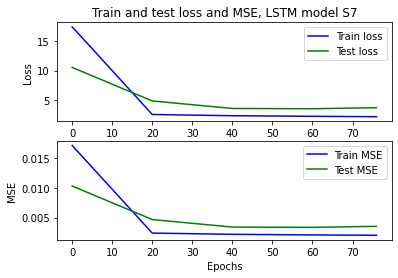

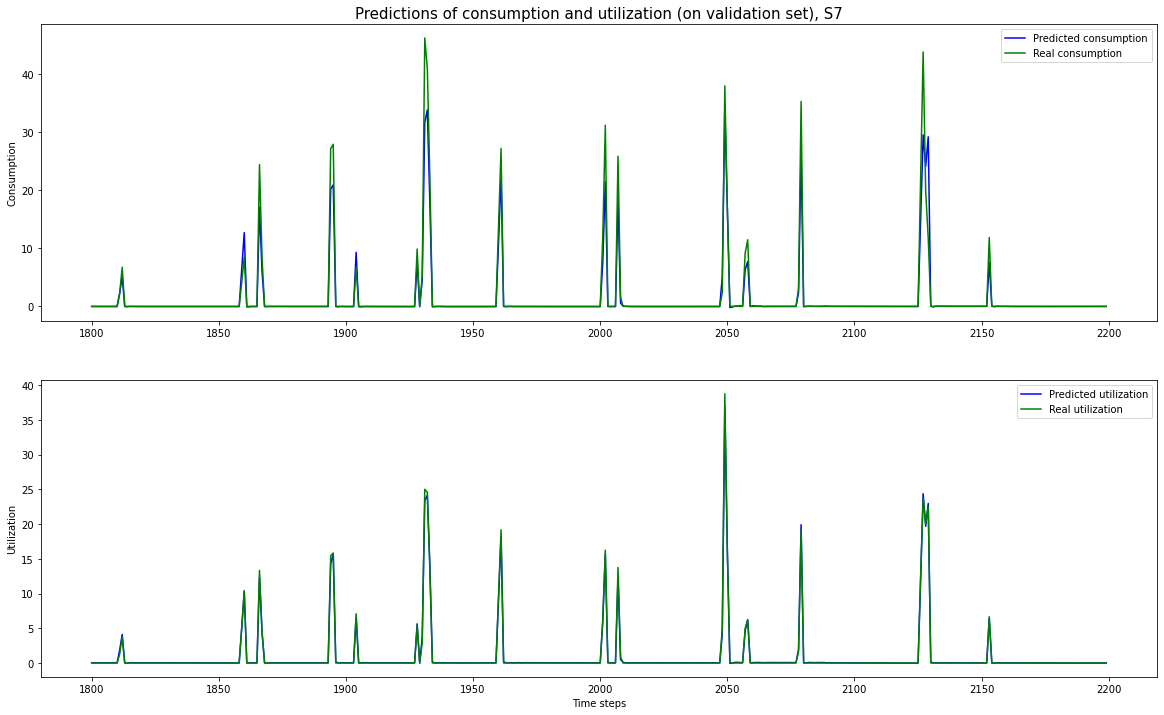

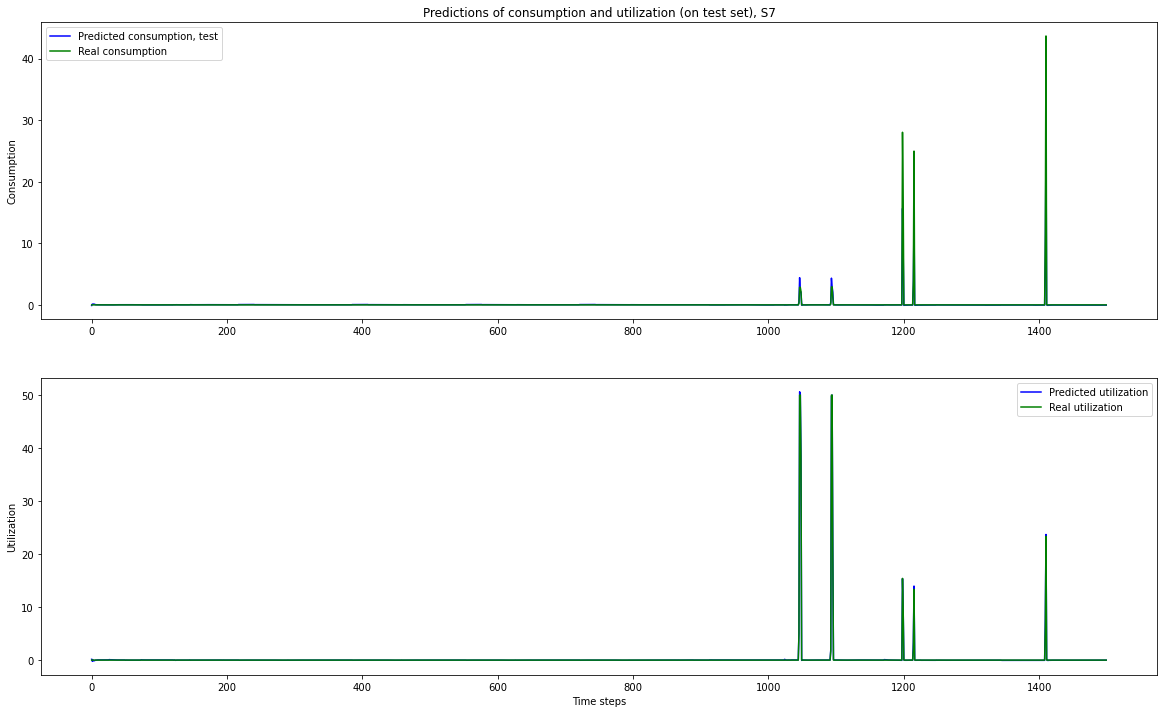

In [120]:
plot_everything(dict_lstm_models_op)

In [58]:
# Save model parameters (weights)
torch.save(min_weights, 'lstm_best_model_all_stations_weights_pickle_final_version.pickle')


In [55]:
model_lstm

LSTM_TimeSeries(
  (lstm): LSTM(280, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

In [56]:
min_weights

OrderedDict([('lstm.weight_ih_l0',
              tensor([[ 5.0257e-01, -3.5184e-01, -7.4340e-01,  ..., -2.3723e-01,
                        7.3897e-01, -2.3374e-01],
                      [ 5.4258e-01,  1.7916e-04,  2.7711e-01,  ..., -8.4471e-02,
                        2.5861e-02,  8.4989e-03],
                      [ 8.4509e-01,  9.9989e-01, -6.8457e-01,  ..., -5.7653e-01,
                       -1.9280e-01, -4.4772e-01],
                      ...,
                      [-9.2687e-02,  3.9449e-01,  2.2639e-01,  ..., -1.0500e-01,
                        1.2160e+00,  5.1406e-01],
                      [ 2.2833e-01,  1.3205e-01,  1.5779e-01,  ...,  1.0145e+00,
                       -9.1265e-01, -3.5958e-02],
                      [ 7.5383e-02,  4.8262e-01,  3.9334e-01,  ...,  9.9766e-01,
                        5.5060e-01,  2.1081e-01]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.2868,  0.1046, -0.3251,  ...,  0.6190, -0.0497,  0.0403],
                      [ 0.1026

### Testing of the best model on the dataset

In [70]:
best_model_pom = best_model

In [105]:
result_sum = pd.DataFrame(columns = list(total_id_locations), index=['Mean C predicted', 'Mean U predicted',
                                                                     'Std C predicted', 'Std U predicted',
                                                                     'Start date', 'End date', 'Num values',
                                                                     'Consumption predicted MSE', 'Utilization predicted MSE',
                                                                     'Max deviation C', 'Max deviation U',
                                                                     'Date deviation C', 'Date deviation U'])
result_sum.index.name = 'Parameters'

In [106]:
def test_lstm_model(real_loader, model_lstm):
    results = pd.DataFrame()
    
    # prediction part on the test set
    pred_consumption = []
    pred_utilization = []
    real_consumption = []
    real_utilization = []
    
    test_loss = 0.0
    test_mse = 0.0

    for inputs, labels in real_loader:
        outputs_real = model_lstm(inputs)
        print(outputs_real.shape)
        loss = criterion(outputs_real.squeeze(), labels)
        # print('Outputs shape: ', outputs.squeeze().shape)
        pred_consumption += outputs_real.detach().numpy()[:, 0].tolist()
        pred_utilization += outputs_real.detach().numpy()[:, 1].tolist()
        real_consumption += labels.numpy()[:, 0].tolist()
        real_utilization += labels.numpy()[:, 1].tolist()
        test_loss += loss.item() * inputs.size(0)
        test_mse += calculate_mse(labels, outputs_real)

    results['Predicted consumption'] = pred_consumption
    results['Predicted utilization'] = pred_utilization
    results['Real consumption'] = real_consumption
    results['Real utilization'] = real_utilization
    
    return results    

In [107]:
batch_size = 1024
for name_id in total_id_locations:
    real_data_sliced = real_data.loc[real_data['location_id'] == name_id]
    real_data_ts = TimeSeriesDataset(real_data_sliced, total_id_locations)
    print('Labels: ', real_data_ts.labels.shape)
    print('Features: ', real_data_ts.features.shape)
    real_data_loader = DataLoader(real_data_ts, batch_size = batch_size)
    
    results_pom_lokacija = test_lstm_model(real_data_loader, best_model_pom)
    
    results_pom_lokacija['Time'] = real_data_sliced['Time'].reset_index(drop=True).copy() # ovo možda neće funkcionirat zbog indexa
    
    result_sum.at['Mean C predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted consumption'].mean()
    result_sum.at['Std C predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted consumption'].std()
    result_sum.at['Mean U predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted utilization'].mean()
    result_sum.at['Std U predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted utilization'].std()
    
    result_sum.at['Start date', name_id] = real_data_sliced['Time'].min()
    result_sum.at['End date', name_id] = real_data_sliced['Time'].max()
    result_sum.at['Num values', name_id] = len(real_data_sliced)
    
    result_sum.at['Consumption predicted MSE', name_id] = mean_squared_error(y_true=results_pom_lokacija['Real consumption'].values,
                                                                             y_pred=results_pom_lokacija['Predicted consumption'].values)
    result_sum.at['Utilization predicted MSE', name_id] = mean_squared_error(y_true=results_pom_lokacija['Real utilization'].values,
                                                                             y_pred=results_pom_lokacija['Predicted utilization'].values)
    
    result_sum.at['Max deviation C', name_id] = (results_pom_lokacija['Predicted consumption'] - results_pom_lokacija['Real consumption']).abs().max()
    result_sum.at['Date deviation C', name_id] = results_pom_lokacija.loc[(
        results_pom_lokacija['Predicted consumption'] - results_pom_lokacija['Real consumption']).abs().idxmax(), 'Time']
    
    result_sum.at['Max deviation U', name_id] = (results_pom_lokacija['Predicted utilization'] - results_pom_lokacija['Real utilization']).abs().max()
    result_sum.at['Date deviation U', name_id] = results_pom_lokacija.loc[(
        results_pom_lokacija['Predicted utilization'] - results_pom_lokacija['Real utilization']).abs().idxmax(), 'Time']
    


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1173, 2])
Features:  torch.Size([1173, 280])
torch.Size([1024, 2])
torch.Size([149, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([978, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([995, 2])
Features:  torch.Size([995, 280])
torch.Size([995, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_10', 'Month_11',
       'Month_12', 

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1200, 2])
Features:  torch.Size([1200, 280])
torch.Size([1024, 2])
torch.Size([176, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1289, 2])
Features:  torch.Size([1289, 280])
torch.Size([1024, 2])
torch.Size([265, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1271, 2])
Features:  torch.Size([1271, 280])
torch.Size([1024, 2])
torch.Size([247, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1219, 2])
Features:  torch.Size([1219, 280])
torch.Size([1024, 2])
torch.Size([195, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1184, 2])
Features:  torch.Size([1184, 280])
torch.Size([1024, 2])
torch.Size([160, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_3', 'Month_1', 'Month_2', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([407, 2])
Features:  torch.Size([407, 280])
torch.Size([407, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2745, 2])
Features:  torch.Size([2745, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([697, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2747, 2])
Features:  torch.Size([2747, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([699, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1227, 2])
Features:  torch.Size([1227, 280])
torch.Size([1024, 2])
torch.Size([203, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_4', 'Month_5', 'Month_1', 'Month_2', 'Month_3',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([887, 2])
Features:  torch.Size([887, 280])
torch.Size([887, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2738, 2])
Features:  torch.Size([2738, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([690, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1331, 2])
Features:  torch.Size([1331, 280])
torch.Size([1024, 2])
torch.Size([307, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2746, 2])
Features:  torch.Size([2746, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([698, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1173, 2])
Features:  torch.Size([1173, 280])
torch.Size([1024, 2])
torch.Size([149, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1234, 2])
Features:  torch.Size([1234, 280])
torch.Size([1024, 2])
torch.Size([210, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1855, 2])
Features:  torch.Size([1855, 280])
torch.Size([1024, 2])
torch.Size([831, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1067, 2])
Features:  torch.Size([1067, 280])
torch.Size([1024, 2])
torch.Size([43, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1286, 2])
Features:  torch.Size([1286, 280])
torch.Size([1024, 2])
torch.Size([262, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1215, 2])
Features:  torch.Size([1215, 280])
torch.Size([1024, 2])
torch.Size([191, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1597, 2])
Features:  torch.Size([1597, 280])
torch.Size([1024, 2])
torch.Size([573, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_7', 'Month_8', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([920, 2])
Features:  torch.Size([920, 280])
torch.Size([920, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1178, 2])
Features:  torch.Size([1178, 280])
torch.Size([1024, 2])
torch.Size([154, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1562, 2])
Features:  torch.Size([1562, 280])
torch.Size([1024, 2])
torch.Size([538, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1473, 2])
Features:  torch.Size([1473, 280])
torch.Size([1024, 2])
torch.Size([449, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1297, 2])
Features:  torch.Size([1297, 280])
torch.Size([1024, 2])
torch.Size([273, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([862, 2])
Features:  torch.Size([862, 280])
torch.Size([862, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([1024, 2])
torch.Size([325, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2893, 2])
Features:  torch.Size([2893, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([845, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1248, 2])
Features:  torch.Size([1248, 280])
torch.Size([1024, 2])
torch.Size([224, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_5', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Tuesday', 'Day_Wednesday', 'Day_Monday', 'Day_Thursay',
       'Day_Friday', 'Day_Saturday', 'Day_Sunday'],
      dtype='object')
Labels:  torch.Size([13, 2])
Features:  torch.Size([13, 280])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([13, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2714, 2])
Features:  torch.Size([2714, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([666, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1212, 2])
Features:  torch.Size([1212, 280])
torch.Size([1024, 2])
torch.Size([188, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1857, 2])
Features:  torch.Size([1857, 280])
torch.Size([1024, 2])
torch.Size([833, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1271, 2])
Features:  torch.Size([1271, 280])
torch.Size([1024, 2])
torch.Size([247, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1833, 2])
Features:  torch.Size([1833, 280])
torch.Size([1024, 2])
torch.Size([809, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1852, 2])
Features:  torch.Size([1852, 280])
torch.Size([1024, 2])
torch.Size([828, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_9', 'Month_10', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1485, 2])
Features:  torch.Size([1485, 280])
torch.Size([1024, 2])
torch.Size([461, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1370, 2])
Features:  torch.Size([1370, 280])
torch.Size([1024, 2])
torch.Size([346, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1331, 2])
Features:  torch.Size([1331, 280])
torch.Size([1024, 2])
torch.Size([307, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1340, 2])
Features:  torch.Size([1340, 280])
torch.Size([1024, 2])
torch.Size([316, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2798, 2])
Features:  torch.Size([2798, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([750, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1029, 2])
Features:  torch.Size([1029, 280])
torch.Size([1024, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([5, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1251, 2])
Features:  torch.Size([1251, 280])
torch.Size([1024, 2])
torch.Size([227, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([867, 2])
Features:  torch.Size([867, 280])
torch.Size([867, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2742, 2])
Features:  torch.Size([2742, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([694, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1832, 2])
Features:  torch.Size([1832, 280])
torch.Size([1024, 2])
torch.Size([808, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_10', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([955, 2])
Features:  torch.Size([955, 280])
torch.Size([955, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1256, 2])
Features:  torch.Size([1256, 280])
torch.Size([1024, 2])
torch.Size([232, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2747, 2])
Features:  torch.Size([2747, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([699, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_1',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2337, 2])
Features:  torch.Size([2337, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([289, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2743, 2])
Features:  torch.Size([2743, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([695, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2744, 2])
Features:  torch.Size([2744, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([696, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1210, 2])
Features:  torch.Size([1210, 280])
torch.Size([1024, 2])
torch.Size([186, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1409, 2])
Features:  torch.Size([1409, 280])
torch.Size([1024, 2])
torch.Size([385, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1298, 2])
Features:  torch.Size([1298, 280])
torch.Size([1024, 2])
torch.Size([274, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1301, 2])
Features:  torch.Size([1301, 280])
torch.Size([1024, 2])
torch.Size([277, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1004, 2])
Features:  torch.Size([1004, 280])
torch.Size([1004, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1342, 2])
Features:  torch.Size([1342, 280])
torch.Size([1024, 2])
torch.Size([318, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1206, 2])
Features:  torch.Size([1206, 280])
torch.Size([1024, 2])
torch.Size([182, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1169, 2])
Features:  torch.Size([1169, 280])
torch.Size([1024, 2])
torch.Size([145, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1197, 2])
Features:  torch.Size([1197, 280])
torch.Size([1024, 2])
torch.Size([173, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2887, 2])
Features:  torch.Size([2887, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([839, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_3', 'Month_4', 'Month_1', 'Month_2', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([734, 2])
Features:  torch.Size([734, 280])
torch.Size([734, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_11', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1317, 2])
Features:  torch.Size([1317, 280])
torch.Size([1024, 2])
torch.Size([293, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1286, 2])
Features:  torch.Size([1286, 280])
torch.Size([1024, 2])
torch.Size([262, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2748, 2])
Features:  torch.Size([2748, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([700, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([841, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1007, 2])
Features:  torch.Size([1007, 280])
torch.Size([1007, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_10', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Day'] = pd.DatetimeIndex(dataframe['Time']).dayofweek
<ipython-input-88-f6db68e7de75>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Labels:  torch.Size([1288, 2])
Features:  torch.Size([1288, 280])
torch.Size([1024, 2])
torch.Size([264, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1131, 2])
Features:  torch.Size([1131, 280])
torch.Size([1024, 2])
torch.Size([107, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1858, 2])
Features:  torch.Size([1858, 280])
torch.Size([1024, 2])
torch.Size([834, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1862, 2])
Features:  torch.Size([1862, 280])
torch.Size([1024, 2])
torch.Size([838, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2740, 2])
Features:  torch.Size([2740, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([692, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1574, 2])
Features:  torch.Size([1574, 280])
torch.Size([1024, 2])
torch.Size([550, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1074, 2])
Features:  torch.Size([1074, 280])
torch.Size([1024, 2])
torch.Size([50, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([796, 2])
Features:  torch.Size([796, 280])
torch.Size([796, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1329, 2])
Features:  torch.Size([1329, 280])
torch.Size([1024, 2])
torch.Size([305, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1486, 2])
Features:  torch.Size([1486, 280])
torch.Size([1024, 2])
torch.Size([462, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1862, 2])
Features:  torch.Size([1862, 280])
torch.Size([1024, 2])
torch.Size([838, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1212, 2])
Features:  torch.Size([1212, 280])
torch.Size([1024, 2])
torch.Size([188, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1605, 2])
Features:  torch.Size([1605, 280])
torch.Size([1024, 2])
torch.Size([581, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1225, 2])
Features:  torch.Size([1225, 280])
torch.Size([1024, 2])
torch.Size([201, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1856, 2])
Features:  torch.Size([1856, 280])
torch.Size([1024, 2])
torch.Size([832, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1001, 2])
Features:  torch.Size([1001, 280])
torch.Size([1001, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2712, 2])
Features:  torch.Size([2712, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([664, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2707, 2])
Features:  torch.Size([2707, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([659, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_7', 'Month_8', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_9', 'Month_10', 'Month

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1060, 2])
Features:  torch.Size([1060, 280])
torch.Size([1024, 2])
torch.Size([36, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1069, 2])
Features:  torch.Size([1069, 280])
torch.Size([1024, 2])
torch.Size([45, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mont

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1233, 2])
Features:  torch.Size([1233, 280])
torch.Size([1024, 2])
torch.Size([209, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1253, 2])
Features:  torch.Size([1253, 280])
torch.Size([1024, 2])
torch.Size([229, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1596, 2])
Features:  torch.Size([1596, 280])
torch.Size([1024, 2])
torch.Size([572, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2747, 2])
Features:  torch.Size([2747, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([699, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1341, 2])
Features:  torch.Size([1341, 280])
torch.Size([1024, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([317, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1862, 2])
Features:  torch.Size([1862, 280])
torch.Size([1024, 2])
torch.Size([838, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1460, 2])
Features:  torch.Size([1460, 280])
torch.Size([1024, 2])
torch.Size([436, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1326, 2])
Features:  torch.Size([1326, 280])
torch.Size([1024, 2])
torch.Size([302, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1327, 2])
Features:  torch.Size([1327, 280])
torch.Size([1024, 2])
torch.Size([303, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1859, 2])
Features:  torch.Size([1859, 280])
torch.Size([1024, 2])
torch.Size([835, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1078, 2])
Features:  torch.Size([1078, 280])
torch.Size([1024, 2])
torch.Size([54, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1858, 2])
Features:  torch.Size([1858, 280])
torch.Size([1024, 2])
torch.Size([834, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1161, 2])
Features:  torch.Size([1161, 280])
torch.Size([1024, 2])
torch.Size([137, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_7', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1007, 2])
Features:  torch.Size([1007, 280])
torch.Size([1007, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1368, 2])
Features:  torch.Size([1368, 280])
torch.Size([1024, 2])
torch.Size([344, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
  

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1370, 2])
Features:  torch.Size([1370, 280])
torch.Size([1024, 2])
torch.Size([346, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1352, 2])
Features:  torch.Size([1352, 280])
torch.Size([1024, 2])
torch.Size([328, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_4', 'Month_5', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([852, 2])
Features:  torch.Size([852, 280])
torch.Size([852, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1118, 2])
Features:  torch.Size([1118, 280])
torch.Size([1024, 2])
torch.Size([94, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
      

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1854, 2])
Features:  torch.Size([1854, 280])
torch.Size([1024, 2])
torch.Size([830, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_11', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1023, 2])
Features:  torch.Size([1023, 280])
torch.Size([1023, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
  

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1312, 2])
Features:  torch.Size([1312, 280])
torch.Size([1024, 2])
torch.Size([288, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1295, 2])
Features:  torch.Size([1295, 280])
torch.Size([1024, 2])
torch.Size([271, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1104, 2])
Features:  torch.Size([1104, 280])
torch.Size([1024, 2])
torch.Size([80, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1260, 2])
Features:  torch.Size([1260, 280])
torch.Size([1024, 2])
torch.Size([236, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1319, 2])
Features:  torch.Size([1319, 280])
torch.Size([1024, 2])
torch.Size([295, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([223, 2])
Features:  torch.Size([223, 280])
torch.Size([223, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1232, 2])
Features:  torch.Size([1232, 280])
torch.Size([1024, 2])
torch.Size([208, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1125, 2])
Features:  torch.Size([1125, 280])
torch.Size([1024, 2])
torch.Size([101, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1254, 2])
Features:  torch.Size([1254, 280])
torch.Size([1024, 2])
torch.Size([230, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1563, 2])
Features:  torch.Size([1563, 280])
torch.Size([1024, 2])
torch.Size([539, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2846, 2])
Features:  torch.Size([2846, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([798, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1259, 2])
Features:  torch.Size([1259, 280])
torch.Size([1024, 2])
torch.Size([235, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1405, 2])
Features:  torch.Size([1405, 280])
torch.Size([1024, 2])
torch.Size([381, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1604, 2])
Features:  torch.Size([1604, 280])
torch.Size([1024, 2])
torch.Size([580, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([615, 2])
Features:  torch.Size([615, 280])
torch.Size([615, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1860, 2])
Features:  torch.Size([1860, 280])
torch.Size([1024, 2])
torch.Size([836, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2575, 2])
Features:  torch.Size([2575, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([527, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1021, 2])
Features:  torch.Size([1021, 280])
torch.Size([1021, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1854, 2])
Features:  torch.Size([1854, 280])
torch.Size([1024, 2])
torch.Size([830, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1207, 2])
Features:  torch.Size([1207, 280])
torch.Size([1024, 2])
torch.Size([183, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2716, 2])
Features:  torch.Size([2716, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([668, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1854, 2])
Features:  torch.Size([1854, 280])
torch.Size([1024, 2])
torch.Size([830, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1268, 2])
Features:  torch.Size([1268, 280])
torch.Size([1024, 2])
torch.Size([244, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([431, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1860, 2])
Features:  torch.Size([1860, 280])
torch.Size([1024, 2])
torch.Size([836, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2738, 2])
Features:  torch.Size([2738, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([690, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([483, 2])
Features:  torch.Size([483, 280])
torch.Size([483, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Wednesday', 'Day_Monday', 'Day_Tuesday', 'Day_Thursay',
       'Day_Friday', 'Day_Saturday', 'Day_Sunday'],
      dtype='object')
Labels:  torch.Size([1, 2])
Features:  torch.Size([1, 280])
torch.Size([1, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1565, 2])
Features:  torch.Size([1565, 280])
torch.Size([1024, 2])
torch.Size([541, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1580, 2])
Features:  torch.Size([1580, 280])
torch.Size([1024, 2])
torch.Size([556, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1236, 2])
Features:  torch.Size([1236, 280])
torch.Size([1024, 2])
torch.Size([212, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_11', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1254, 2])
Features:  torch.Size([1254, 280])
torch.Size([1024, 2])
torch.Size([230, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1332, 2])
Features:  torch.Size([1332, 280])
torch.Size([1024, 2])
torch.Size([308, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([986, 2])
Features:  torch.Size([986, 280])
torch.Size([986, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1240, 2])
Features:  torch.Size([1240, 280])
torch.Size([1024, 2])
torch.Size([216, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1322, 2])
Features:  torch.Size([1322, 280])
torch.Size([1024, 2])
torch.Size([298, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1342, 2])
Features:  torch.Size([1342, 280])
torch.Size([1024, 2])
torch.Size([318, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1358, 2])
Features:  torch.Size([1358, 280])
torch.Size([1024, 2])
torch.Size([334, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([649, 2])
Features:  torch.Size([649, 280])
torch.Size([649, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1860, 2])
Features:  torch.Size([1860, 280])
torch.Size([1024, 2])
torch.Size([836, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1597, 2])
Features:  torch.Size([1597, 280])
torch.Size([1024, 2])
torch.Size([573, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1571, 2])
Features:  torch.Size([1571, 280])
torch.Size([1024, 2])
torch.Size([547, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([1024, 2])
torch.Size([820, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1859, 2])
Features:  torch.Size([1859, 280])
torch.Size([1024, 2])
torch.Size([835, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1861, 2])
Features:  torch.Size([1861, 280])
torch.Size([1024, 2])
torch.Size([837, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([913, 2])
Features:  torch.Size([913, 280])
torch.Size([913, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1106, 2])
Features:  torch.Size([1106, 280])
torch.Size([1024, 2])
torch.Size([82, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Sunday', 'Day_Monday', 'Day_Tuesday', 'Day_Wednesday',
       'Day_Thursay', 'Day_Friday', 'Day_Saturday'],
      dtype='object')
Labels:  torch.Size([10, 2])
Features:  torch.Size([10, 280])
torch.Size([10, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1153, 2])
Features:  torch.Size([1153, 280])
torch.Size([1024, 2])
torch.Size([129, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1215, 2])
Features:  torch.Size([1215, 280])
torch.Size([1024, 2])
torch.Size([191, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1105, 2])
Features:  torch.Size([1105, 280])
torch.Size([1024, 2])
torch.Size([81, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2591, 2])
Features:  torch.Size([2591, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([543, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Mont

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1164, 2])
Features:  torch.Size([1164, 280])
torch.Size([1024, 2])
torch.Size([140, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1299, 2])
Features:  torch.Size([1299, 280])
torch.Size([1024, 2])
torch.Size([275, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1845, 2])
Features:  torch.Size([1845, 280])
torch.Size([1024, 2])
torch.Size([821, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1332, 2])
Features:  torch.Size([1332, 280])
torch.Size([1024, 2])
torch.Size([308, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1250, 2])
Features:  torch.Size([1250, 280])
torch.Size([1024, 2])
torch.Size([226, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1862, 2])
Features:  torch.Size([1862, 280])
torch.Size([1024, 2])
torch.Size([838, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Monday', 'Day_Sunday', 'Day_Tuesday', 'Day_Wednesday',
       'Day_Thursay', 'Day_Friday', 'Day_Saturday'],
      dtype='object')
Labels:  torch.Size([19, 2])
Features:  torch.Size([19, 280])
torch.Size([19, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'M

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1211, 2])
Features:  torch.Size([1211, 280])
torch.Size([1024, 2])
torch.Size([187, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1144, 2])
Features:  torch.Size([1144, 280])
torch.Size([1024, 2])
torch.Size([120, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_2', 'Month_1', 'Month_3', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([627, 2])
Features:  torch.Size([627, 280])
torch.Size([627, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1236, 2])
Features:  torch.Size([1236, 280])
torch.Size([1024, 2])
torch.Size([212, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1859, 2])
Features:  torch.Size([1859, 280])
torch.Size([1024, 2])
torch.Size([835, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1289, 2])
Features:  torch.Size([1289, 280])
torch.Size([1024, 2])
torch.Size([265, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1134, 2])
Features:  torch.Size([1134, 280])
torch.Size([1024, 2])
torch.Size([110, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1861, 2])
Features:  torch.Size([1861, 280])
torch.Size([1024, 2])
torch.Size([837, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1820, 2])
Features:  torch.Size([1820, 280])
torch.Size([1024, 2])
torch.Size([796, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([1024, 2])
torch.Size([177, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1860, 2])
Features:  torch.Size([1860, 280])
torch.Size([1024, 2])
torch.Size([836, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1289, 2])
Features:  torch.Size([1289, 280])
torch.Size([1024, 2])
torch.Size([265, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([596, 2])
Features:  torch.Size([596, 280])
torch.Size([596, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1492, 2])
Features:  torch.Size([1492, 280])
torch.Size([1024, 2])
torch.Size([468, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2836, 2])
Features:  torch.Size([2836, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([788, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1174, 2])
Features:  torch.Size([1174, 280])
torch.Size([1024, 2])
torch.Size([150, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_

<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Day'] = pd.DatetimeIndex(dataframe['Time']).dayofweek
<ipython-input-88-f6db68e7de75>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

Labels:  torch.Size([2885, 2])
Features:  torch.Size([2885, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([837, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2747, 2])
Features:  torch.Size([2747, 280])
torch.Size([1024, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

torch.Size([1024, 2])
torch.Size([699, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1176, 2])
Features:  torch.Size([1176, 280])
torch.Size([1024, 2])
torch.Size([152, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_7', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_8', 'Month_9

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([884, 2])
Features:  torch.Size([884, 280])
torch.Size([884, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1265, 2])
Features:  torch.Size([1265, 280])
torch.Size([1024, 2])
torch.Size([241, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2939, 2])
Features:  torch.Size([2939, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([891, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_11', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([332, 2])
Features:  torch.Size([332, 280])
torch.Size([332, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1161, 2])
Features:  torch.Size([1161, 280])
torch.Size([1024, 2])
torch.Size([137, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1470, 2])
Features:  torch.Size([1470, 280])
torch.Size([1024, 2])
torch.Size([446, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([2619, 2])
Features:  torch.Size([2619, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([571, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1302, 2])
Features:  torch.Size([1302, 280])
torch.Size([1024, 2])
torch.Size([278, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2618, 2])
Features:  torch.Size([2618, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([570, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month

<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Day'] = pd.DatetimeIndex(dataframe['Time']).dayofweek
<ipython-input-88-f6db68e7de75>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = dataframe['Year'] - 1970
<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

Labels:  torch.Size([1411, 2])
Features:  torch.Size([1411, 280])
torch.Size([1024, 2])
torch.Size([387, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1204, 2])
Features:  torch.Size([1204, 280])
torch.Size([1024, 2])
torch.Size([180, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1201, 2])
Features:  torch.Size([1201, 280])
torch.Size([1024, 2])
torch.Size([177, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1195, 2])
Features:  torch.Size([1195, 280])
torch.Size([1024, 2])
torch.Size([171, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1195, 2])
Features:  torch.Size([1195, 280])
torch.Size([1024, 2])
torch.Size([171, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_10', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([712, 2])
Features:  torch.Size([712, 280])
torch.Size([712, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_11', 'Month_1', 'Month_2',
    

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1195, 2])
Features:  torch.Size([1195, 280])
torch.Size([1024, 2])
torch.Size([171, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([2736, 2])
Features:  torch.Size([2736, 280])
torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([688, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1014, 2])
Features:  torch.Size([1014, 280])
torch.Size([1014, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1575, 2])
Features:  torch.Size([1575, 280])
torch.Size([1024, 2])
torch.Size([551, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
  

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1362, 2])
Features:  torch.Size([1362, 280])
torch.Size([1024, 2])
torch.Size([338, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1862, 2])
Features:  torch.Size([1862, 280])
torch.Size([1024, 2])
torch.Size([838, 2])


<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1861, 2])
Features:  torch.Size([1861, 280])
torch.Size([1024, 2])
torch.Size([837, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1140, 2])
Features:  torch.Size([1140, 280])
torch.Size([1024, 2])
torch.Size([116, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_3', 'Month_1', 'Month_2', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([147, 2])
Features:  torch.Size([147, 280])
torch.Size([147, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
     

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1307, 2])
Features:  torch.Size([1307, 280])
torch.Size([1024, 2])
torch.Size([283, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1235, 2])
Features:  torch.Size([1235, 280])
torch.Size([1024, 2])
torch.Size([211, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1862, 2])
Features:  torch.Size([1862, 280])
torch.Size([1024, 2])
torch.Size([838, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1500, 2])
Features:  torch.Size([1500, 280])
torch.Size([1024, 2])
torch.Size([476, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_7', 'Month_8', 'Month_9', 'Mon

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http


torch.Size([825, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_5', 'Month_6', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([918, 2])
Features:  torch.Size([918, 280])
torch.Size([918, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_11',
       'Month_12',

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1342, 2])
Features:  torch.Size([1342, 280])
torch.Size([1024, 2])
torch.Size([318, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1200, 2])
Features:  torch.Size([1200, 280])
torch.Size([1024, 2])
torch.Size([176, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Labels:  torch.Size([1319, 2])
Features:  torch.Size([1319, 280])
torch.Size([1024, 2])
torch.Size([295, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_8', 'Month_9', 'Month_10', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')
Labels:  torch.Size([1521, 2])
Features:  torch.Size([1521, 280])
torch.Size([1024, 2])
torch.Size([497, 2])
Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_10', 'Month_1', 'Mo

<ipython-input-88-f6db68e7de75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Year'] = pd.DatetimeIndex(dataframe['Time']).year
<ipython-input-88-f6db68e7de75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Month'] = pd.DatetimeIndex(dataframe['Time']).month
<ipython-input-88-f6db68e7de75>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [108]:
result_sum.isna().sum(axis=1)

Parameters
Mean C predicted             0
Mean U predicted             0
Std C predicted              1
Std U predicted              1
Start date                   0
End date                     0
Num values                   0
Consumption predicted MSE    0
Utilization predicted MSE    0
Max deviation C              0
Max deviation U              0
Date deviation C             0
Date deviation U             0
dtype: int64

In [112]:
result_sum.to_csv(r'...\all locations table.csv', sep=';')

In [ ]:
# result_sum is a dataframe that shows effectivness of model on each location

## User input for selected station

In [121]:
# for simulation of user input, real_data is used -- this is a part of data that is not seen when training and that is not used for testing
# real_data is data after the expand_data function (and it has data for all locations that were seen during training)
real_data

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time,Year,Month,Day
0,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-09-12 18:00:00,52,9,0
1,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-09-12 19:00:00,52,9,0
2,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-09-12 20:00:00,52,9,0
3,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-09-12 21:00:00,52,9,0
4,120929.0,Antunovac,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-09-12 22:00:00,52,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380653,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 17:00:00,52,10,6
380654,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 18:00:00,52,10,6
380655,238019.0,Žminj,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-10-16 19:00:00,52,10,6
380656,238019.0,Žminj,Public access - Free access,2022-10-16 20:00:00+00:00,10.000000,2.0,0.0,0.021541,12.0,2022-10-16 20:00:00,52,10,6


In [122]:
# user input
time_start = '2022-09-06'
time_end = '2022-09-20'
location_id = 171102 # this corresponds to Bjelovar

# note: if we want predictions for specific time frame (eg. from 06 to 14 o'clock), 
# time_start and time_end should be expanded with HOUR:MINUTES:SECOND

In [123]:
real_data_pom = real_data[real_data['location_id'] == (location_id)]
real_data_selected = real_data_pom[(real_data_pom['Time'] > time_start) & (real_data_pom['Time'] < time_end)].reset_index(drop=True)
real_data_selected

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time,Year,Month,Day
0,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 01:00:00,52,9,1
1,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 02:00:00,52,9,1
2,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 03:00:00,52,9,1
3,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 04:00:00,52,9,1
4,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 05:00:00,52,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 19:00:00,52,9,0
331,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 20:00:00,52,9,0
332,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 21:00:00,52,9,0
333,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 22:00:00,52,9,0


In [124]:
name = real_data_selected['location_friendlyname'][0]
name

#this name will be used later for visualization

'Bjelovar'

In [125]:
real_data_selected_filtered = TimeSeriesDataset(real_data_selected, total_id_locations)
real_selected_loader = DataLoader(real_data_selected_filtered, batch_size = 1024, shuffle=False)

Index(['location_id', 'location_friendlyname', 'location_accesstype_title',
       'charging_hour', 'utilization', 'connector_count',
       'congested_connectors', 'energy_consumption', 'charging_minutes',
       'Time', 'Year', 'Month_9', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_10', 'Month_11',
       'Month_12', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')


In [126]:
real_data_selected_filtered.features.shape

torch.Size([335, 280])

In [127]:
real_data_selected_filtered.labels.shape

torch.Size([335, 2])

In [128]:
real_selected_loader.dataset.features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [129]:
results_selected_location = test_lstm_model(real_selected_loader, best_model_pom)
results_selected_location['Time'] = real_data_selected['Time'].copy()
results_selected_location

torch.Size([335, 2])


,Predicted consumption,Predicted utilization,Real consumption,Real utilization,Time
0,-0.070481,-0.012777,0.0,0.0,2022-09-06 01:00:00
1,0.035750,0.028249,0.0,0.0,2022-09-06 02:00:00
2,0.044735,0.067089,0.0,0.0,2022-09-06 03:00:00
3,0.021706,0.078202,0.0,0.0,2022-09-06 04:00:00
4,0.012923,0.053161,0.0,0.0,2022-09-06 05:00:00
...,...,...,...,...,...
330,-0.025092,0.014353,0.0,0.0,2022-09-19 19:00:00
331,-0.025116,0.013519,0.0,0.0,2022-09-19 20:00:00
332,-0.025126,0.012710,0.0,0.0,2022-09-19 21:00:00
333,-0.025127,0.011932,0.0,0.0,2022-09-19 22:00:00


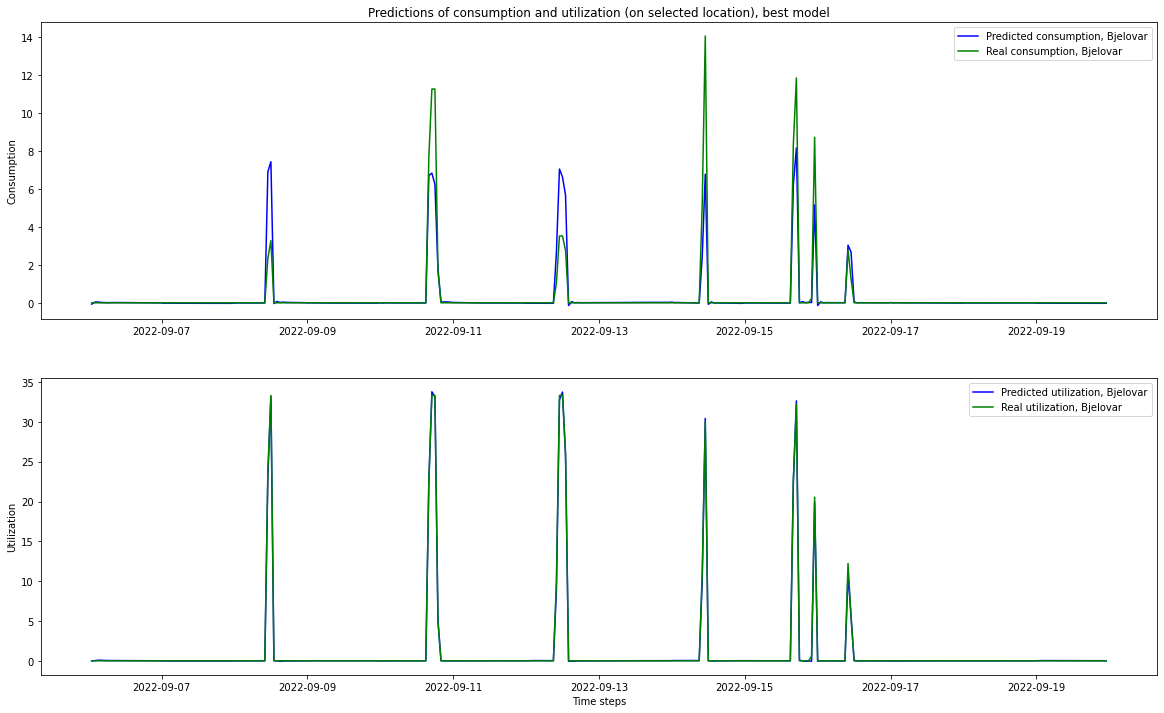

In [130]:
# predviđanja
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
ax1.plot(results_selected_location['Time'], results_selected_location['Predicted consumption'], color='b', label='Predicted consumption, ' + str(name))
ax1.plot(results_selected_location['Time'], results_selected_location['Real consumption'], color='g', label='Real consumption, ' + str(name))
ax1.set(ylabel='Consumption')
ax1.legend()
ax1.set_title('Predictions of consumption and utilization (on selected location), best model')
    
ax2.plot(results_selected_location['Time'], results_selected_location['Predicted utilization'], color='b', label='Predicted utilization, ' + str(name))
ax2.plot(results_selected_location['Time'], results_selected_location['Real utilization'], color='g', label='Real utilization, ' + str(name))
ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
ax2.legend()
    
plt.show()

## Transformer model

In [22]:
# Define the Transformer network
class TransformerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_heads, dropout):
        super(TransformerNet, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(input_size, num_heads, hidden_size, dropout),
            num_layers
        )
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        output = self.transformer(input)
        output = self.fc(output[:, -1, :])
        #output = output.mean(1)
        return output


In [23]:
# Define the dataset for the Transformer
class TransformerDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.sequence_length]
        label = self.data[idx+self.sequence_length]
        return input_seq, label

In [24]:
# Function to calculate the mean squared error
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true.detach().numpy(), y_pred.detach().numpy())

In [62]:
lookback = 12
train_data_transformer = TransformerDataset(train_data_filtered, lookback)
val_data_transformer = TransformerDataset(val_data_filtered, lookback)
test_data_transformer = TransformerDataset(test_data_filtered, lookback)

In [63]:
train_data_filtered.labels.shape

torch.Size([299932, 2])

In [85]:
# Define the dataloader for the Transformer
batch_size = 512
transformer_train_dataloader = DataLoader(train_data_transformer, batch_size=batch_size, shuffle=False)
transformer_val_dataloader = DataLoader(val_data_transformer, batch_size=batch_size, shuffle=False)
transformer_test_dataloader = DataLoader(test_data_transformer, batch_size = batch_size, shuffle=False)

In [86]:
for x,y in transformer_train_dataloader:
    print(x[0].shape, y[1].shape)
    break
    
# this is a random check of data shape

torch.Size([512, 12, 52]) torch.Size([512, 2])


In [140]:
# same thing as for the LSTM model - this dictionary is only used for storing
dict_transformer_model = {}

In [143]:
dict_transformer_model['Setup 8'] = {}

In [41]:
dict_transformer_model['Setup 5']['Parameters'] = {'batch size': 2048,
                                                   'lookback': 2,
                                                   'hidden size': 256,
                                                   'num layers': 2,
                                                    'num heads': 1,
                                                   'learning rate': 0.0005,
                                                   'optimizer': 'RMSprop'}

In [52]:
dict_transformer_model['Setup 6']['Parameters'] = {'batch size': 256,
                                                   'lookback': 2,
                                                   'hidden size': 64,
                                                   'num layers': 2,
                                                    'num heads': 1,
                                                   'learning rate': 0.001,
                                                   'optimizer': 'RMSprop'}

In [90]:
dict_transformer_model['Setup 7']['Parameters'] = {'batch size': 512,
                                                   'lookback': 12,
                                                   'hidden size': 64,
                                                   'num layers': 3,
                                                    'num heads': 1,
                                                   'learning rate': 0.001,
                                                   'optimizer': 'RMSprop'}

In [144]:
dict_transformer_model['Setup 8']['Parameters'] = {'batch size': 512,
                                                   'lookback': 12,
                                                   'hidden size': 128,
                                                   'num layers': 2,
                                                    'num heads': 1,
                                                   'learning rate': 0.001,
                                                   'optimizer': 'RMSprop'}

# the best results are for this configuration

In [145]:
dict_transformer_model['Setup 8']['Results'] = {}

In [95]:
train_loss_list = []
train_mse_list = []
test_loss_list = []
test_mse_list = []
epoch_list = []
predicted_values_consumption = pd.DataFrame()
predicted_values_utilization = pd.DataFrame()
real_values_consumption = pd.DataFrame()
real_values_utilization = pd.DataFrame()

pred_consumption_test = pd.DataFrame()
pred_utilization_test = pd.DataFrame()
real_consumption_test = pd.DataFrame()
real_utilization_test = pd.DataFrame()


In [124]:
train_data_transformer.data.features.shape[0]

230167

In [45]:
transformer_train_dataloader.dataset.data.features.shape

torch.Size([299932, 52])

In [96]:
# Define the Transformer network
input_size = transformer_train_dataloader.dataset.data.features.shape[1]
hidden_size = 128
output_size = transformer_train_dataloader.dataset.data.labels.shape[1]
num_layers = 2
num_heads = 1
dropout = 0.1
model_transformer = TransformerNet(input_size, hidden_size, output_size, num_layers, num_heads, dropout)
len_train_data = train_data_transformer.data.features.shape[0]
len_val_data = val_data_transformer.data.features.shape[0]
len_test_data = test_data_transformer.data.features.shape[0]

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
counter = 0

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_mse = 0.0
    val_mse = 0.0
    
    # Training
    model.train()
    for inputs, labels in transformer_train_dataloader:
        optimizer.zero_grad()
        inputs = inputs[0]
        real_outputs_train = labels[1]
        outputs_train = model_transformer(inputs)
        loss = criterion(outputs_train, real_outputs_train)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_mse += calculate_mse(real_outputs_train, outputs_train)
    #print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss/len_train_data:.4f} - Train MSE: {train_mse/len_train_data:.4}")
    
    predicted_values_pom1 = []
    predicted_values_pom2 = []
    real_values_pom1 = []
    real_values_pom2 = []
    
    # Testing
    model_transformer.eval()
    
    with torch.no_grad():
        for inputs, labels in transformer_val_dataloader:
            inputs_val = inputs[0]
            real_outputs_val = labels[1]
            outputs_val = model_transformer(inputs_val)
            loss = criterion(outputs_val, real_outputs_val)
            
            predicted_values_pom1 += outputs_val.numpy()[:, 0].tolist()
            predicted_values_pom2 += outputs_val.numpy()[:, 1].tolist()
            real_values_pom1 += real_outputs_val.numpy()[:, 0].tolist()
            real_values_pom2 += real_outputs_val.numpy()[:, 1].tolist()
            val_loss += loss.item() * inputs_val.size(0)
            val_mse += calculate_mse(real_outputs_val, outputs_val)
            
            #val_loss += loss.item() * inputs_val.size(0)
            #val_mse += calculate_mse(real_outputs_val, outputs_val)
            
    if epoch == 0:
        real_values_consumption['Epoch ' + str(epoch)] = real_values_pom1
        real_values_utilization['Epoch ' + str(epoch)] = real_values_pom2
        val_loss_old = (val_loss/len_val_data)
        
        min_val_loss = val_loss_old
        min_weights = model_transformer.state_dict()
        
    if epoch > 0:
        val_loss_new = val_loss/len_val_data
        if val_loss_new > min_val_loss: # some kind of an Early Stopping callback
            counter += 1
        else:
            min_val_loss = val_loss_new 
            min_weights = model_transformer.state_dict()
            best_model = model_transformer
            predicted_values_consumption['The best epoch'] = predicted_values_pom1
            predicted_values_utilization['The best epoch'] = predicted_values_pom2
            counter = 0
            print('Currently best epoch: ', epoch)
            print('Minimum validation loss: ', min_val_loss)
            print('Current validation MSE: ', val_mse/len_val_data)
            #print('Minimum validation loss: ', min_val_loss)
    
    if epoch%20 == 0:
        # Print training and test errors
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss/len_train_data:.4f} - Val Loss: {val_loss/len_val_data:.4f} - Train MSE: {train_mse/len_train_data:.4f} - Val MSE: {val_mse/len_val_data:.4f}")
        train_loss_list.append(train_loss/len_train_data)
        train_mse_list.append(train_mse/len_train_data)
        test_loss_list.append(val_loss/len_val_data)
        test_mse_list.append(val_mse/len_val_data)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
            

    if counter == 30: 
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train MSE: {train_mse/len_train_data:.4f} - Val MSE: {val_mse/len_val_data:.4f}")
        print(f"[Early stopping] Epoch {epoch}/{num_epochs} - Train loss: {train_loss/len_train_data:.4f} - Val loss: {val_loss/len_val_data:.4f}")
        print('Minimum validation loss: ', min_val_loss)
        print('Current validation loss: ', val_loss_new)
        train_loss_list.append(train_loss/len_train_data)
        train_mse_list.append(train_mse/len_train_data)
        test_loss_list.append(val_loss/len_val_data)
        test_mse_list.append(val_mse/len_val_data)
        epoch_list.append(epoch)
        predicted_values_consumption['Epoch ' + str(epoch)] = predicted_values_pom1
        predicted_values_utilization['Epoch ' + str(epoch)] = predicted_values_pom2
        break


Epoch 0/1000 - Training Loss: 20.4651 - Val Loss: 27.2852 - Train MSE: 0.0400 - Val MSE: 0.0533
Currently best epoch:  1
Minimum validation loss:  25.193234618816845
Current validation MSE:  0.04920554676149038
Currently best epoch:  2
Minimum validation loss:  22.940349430897868
Current validation MSE:  0.04480552528367913
Currently best epoch:  3
Minimum validation loss:  22.344691254059313
Current validation MSE:  0.04364202816495473
Currently best epoch:  4
Minimum validation loss:  22.062785310966927
Current validation MSE:  0.04309152249169434
Currently best epoch:  6
Minimum validation loss:  21.642394384880586
Current validation MSE:  0.042270789898125785
Currently best epoch:  7
Minimum validation loss:  21.631649333175027
Current validation MSE:  0.04224965643297281
Currently best epoch:  8
Minimum validation loss:  20.86768869602518
Current validation MSE:  0.040757485430240215
Currently best epoch:  9
Minimum validation loss:  20.4016731509639
Current validation MSE:  0.039

In [97]:
sum(p.numel() for p in model_transformer.parameters())

49554

In [48]:
model_transformer

TransformerNet(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=52, out_features=52, bias=True)
        )
        (linear1): Linear(in_features=52, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=52, bias=True)
        (norm1): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=52, out_features=2, bias=True)
)

In [99]:
# the prediction part
pred_consumption = []
pred_utilization = []
real_consumption = []
real_utilization = []

test_loss = 0.0
test_mse = 0.0

for inputs, labels in transformer_test_dataloader:
    inputs_test = inputs[0]
    real_outputs_test = labels[1]
    outputs_test = best_model(inputs_test)
    loss = criterion(outputs_test, real_outputs_test)
    # print('Outputs shape: ', outputs.squeeze().shape)
    pred_consumption += outputs_test.detach().numpy()[:, 0].tolist()
    pred_utilization += outputs_test.detach().numpy()[:, 1].tolist()
    real_consumption += real_outputs_test.numpy()[:, 0].tolist()
    real_utilization += real_outputs_test.numpy()[:, 1].tolist()
    test_loss += loss.item() * inputs_test.size(0)
    test_mse += calculate_mse(real_outputs_test, outputs_test)

pred_consumption_test['Final'] = pred_consumption
pred_utilization_test['Final'] = pred_utilization
real_consumption_test['Final'] = real_consumption
real_utilization_test['Final'] = real_utilization


In [100]:
dict_transformer_model['Setup 7']['Results'] = {'Train loss': train_loss_list,
                              'Train MSE': train_mse_list,
                              'Test loss': test_loss_list,
                              'Test MSE': test_mse_list,
                              'Epochs': epoch_list,
                              'Predictions consumption validation:': predicted_values_consumption,
                              'Prediction utilization validation:': predicted_values_utilization,
                              'Real values consumption validation:': real_values_consumption,
                               'Real values utilization validation:': real_values_utilization,
                              'Predictions consumption test:': pred_consumption_test,
                              'Prediction utilization test:': pred_utilization_test,
                              'Real values consumption test:': real_consumption_test,
                               'Real values utilization test:': real_utilization_test}

In [105]:
def plot_everything_transformer(dict_model):
    pom_dict_s1 = dict_model['Setup 8']['Results'].copy()
    
    fig, (ax1, ax2) = plt.subplots(2)
    
    ax1.plot(pom_dict_s1['Epochs'], pom_dict_s1['Train loss'], color='b', label='Train loss')
    ax1.plot(pom_dict_s1['Epochs'], pom_dict_s1['Test loss'], color='g', label='Test loss')
    ax1.set(ylabel='Loss')
    ax1.legend()
    ax1.set_title('Train and test loss and MSE, Transformer model')
    
    ax2.plot(pom_dict_s1['Epochs'], pom_dict_s1['Train MSE'], color='b', label='Train MSE')
    ax2.plot(pom_dict_s1['Epochs'], pom_dict_s1['Test MSE'], color='g', label='Test MSE')
    ax2.set(xlabel = 'Epochs', ylabel = 'MSE')
    ax2.legend()
    
    # plt.savefig('Transformer loss lokacije, currently best S7.png')
    
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
    ax1.plot(pom_dict_s1['Predictions consumption validation:'].iloc[1600:1800, 1], color='b', label='Predicted consumption')
    ax1.plot(pom_dict_s1['Real values consumption validation:'].iloc[1600:1800, 0], color='g', label='Real consumption')
    ax1.set(ylabel='Consumption')
    ax1.legend()
    ax1.set_title('Predictions of consumption and utilization (on validation set), S7', fontsize=15)
    
    ax2.plot(pom_dict_s1['Prediction utilization validation:'].iloc[1600:1800, 1], color='b', label='Predicted utilization')
    ax2.plot(pom_dict_s1['Real values utilization validation:'].iloc[1600:1800, 0], color='g', label='Real utilization')
    ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
    ax2.legend()
    
    # plt.savefig('Transformer predictions on validation set, (currently) best epoch, S7 lok.png')
    
    plt.show()
    
    # predviđanja
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
    
    ax1.plot(pom_dict_s1['Predictions consumption test:'].iloc[1600:1800, 0], color='b', label='Predicted consumption, test')
    ax1.plot(pom_dict_s1['Real values consumption test:'].iloc[1600:1800, 0], color='g', label='Real consumption')
    ax1.set(ylabel='Consumption')
    ax1.legend()
    ax1.set_title('Predictions of consumption and utilization (on test set), S7')
    
    ax2.plot(pom_dict_s1['Prediction utilization test:'].iloc[1600:1800, 0], color='b', label='Predicted utilization')
    ax2.plot(pom_dict_s1['Real values utilization test:'].iloc[1600:1800, 0], color='g', label='Real utilization')
    ax2.set(xlabel = 'Time steps', ylabel = 'Utilization')
    ax2.legend()
    
    # plt.savefig('Transformer predictions on test set, (currently) best epoch, S7 lok.png')
    
    plt.show()

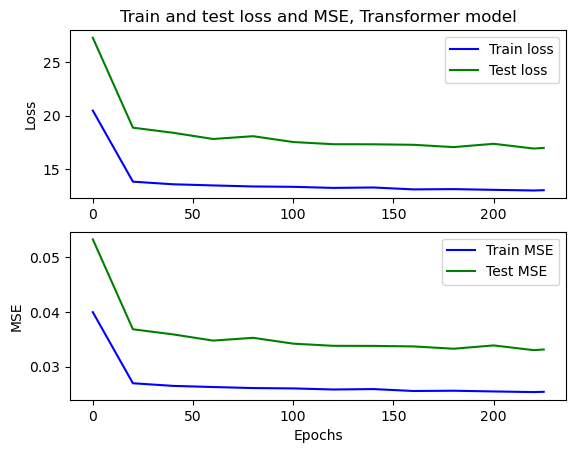

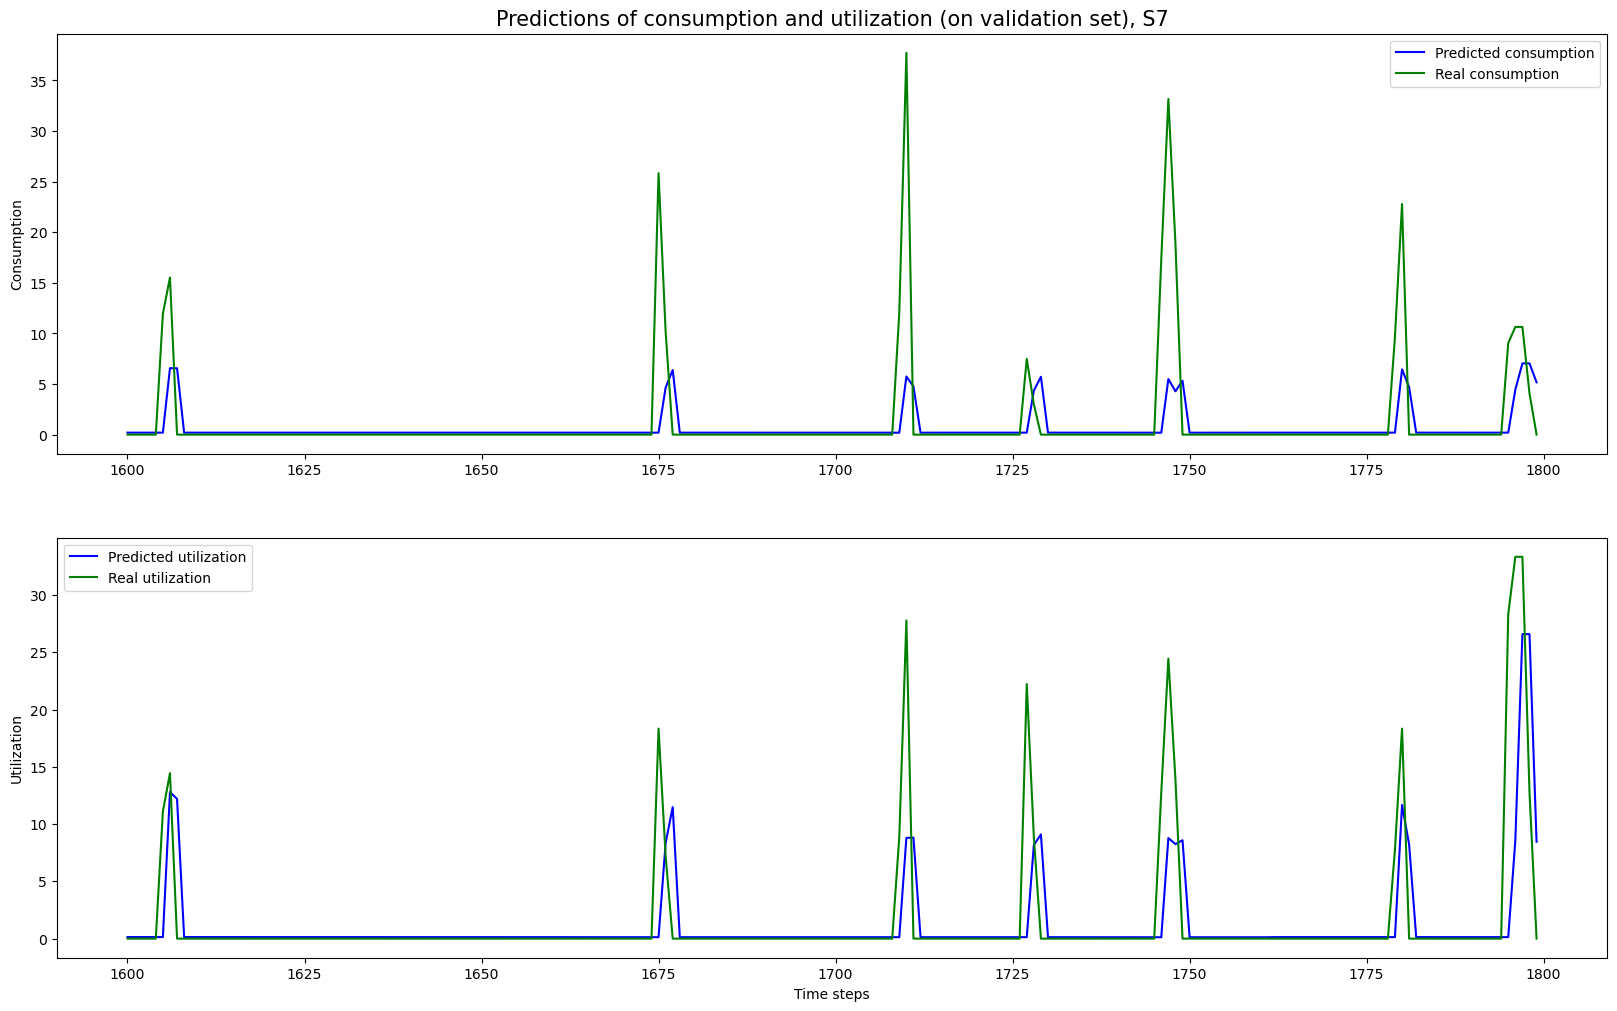

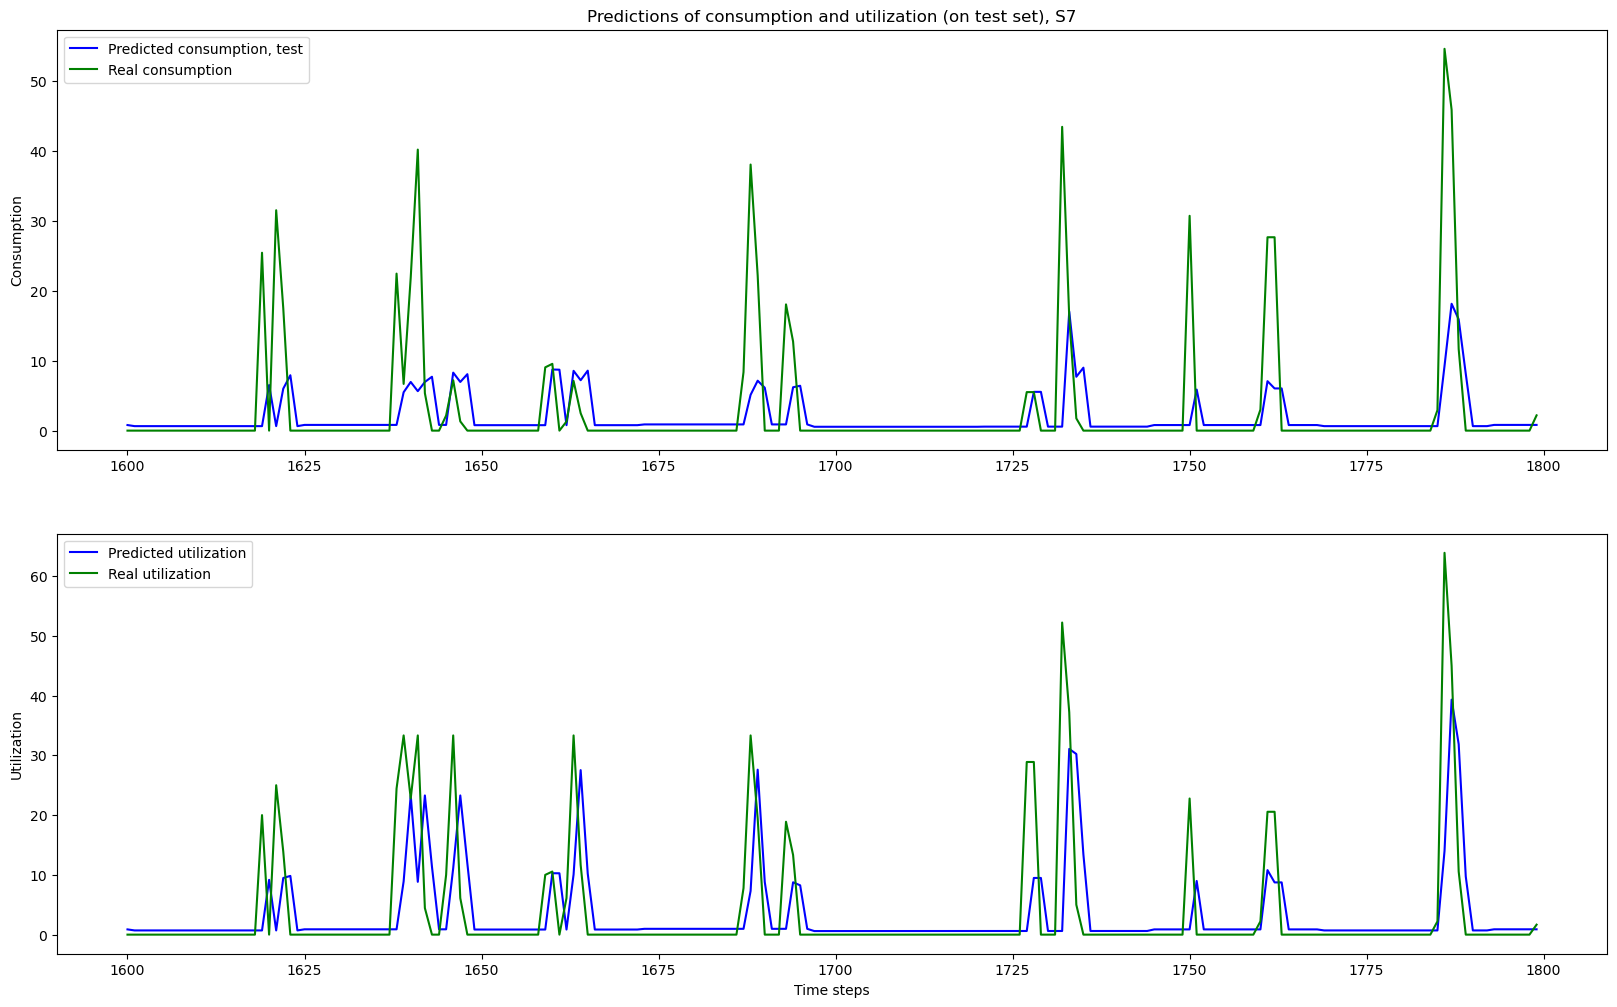

In [106]:
plot_everything_transformer(dict_transformer_model)

In [103]:
real_outputs_test.shape

torch.Size([327, 2])

In [107]:
# Save model parameters
torch.save(min_weights, 'transformer_best_model_weights_location_pickle_final_version.pickle')

## Testing of the best model on dataset

In [ ]:
best_model_transformer = best_model

In [81]:
result_sum_transformer = pd.DataFrame(columns = list(total_id_locations), index=['Mean C predicted', 'Mean U predicted',
                                                                     'Std C predicted', 'Std U predicted',
                                                                     'Start date', 'End date', 'Num values',
                                                                     'Consumption predicted MSE', 'Utilization predicted MSE',
                                                                     'Max deviation C', 'Max deviation U',
                                                                     'Date deviation C', 'Date deviation U'])
result_sum_transformer.index.name = 'Parameters'

In [ ]:
def test_transformer_model(real_loader, model_transformer):
    results = pd.DataFrame()
    
    # prediction part on the test set
    pred_consumption = []
    pred_utilization = []
    real_consumption = []
    real_utilization = []
    
    test_loss = 0.0
    test_mse = 0.0

    for inputs, labels in real_loader:
        inputs_test = inputs[0]
        real_outputs = labels[1]
        outputs_predicted = model_transformer(inputs_test)
        loss = criterion(outputs_predicted, real_outputs)
        # print('Outputs shape: ', outputs.squeeze().shape)
        pred_consumption += outputs_predicted.detach().numpy()[:, 0].tolist()
        pred_utilization += outputs_predicted.detach().numpy()[:, 1].tolist()
        real_consumption += real_outputs.numpy()[:, 0].tolist()
        real_utilization += real_outputs.numpy()[:, 1].tolist()
        test_loss += loss.item() * inputs_test.size(0)
        test_mse += calculate_mse(real_outputs, outputs_predicted)

    results['Predicted consumption'] = pred_consumption
    results['Predicted utilization'] = pred_utilization
    results['Real consumption'] = real_consumption
    results['Real utilization'] = real_utilization
    
    return results    

In [ ]:
batch_size = 512
for name_id in total_id_locations:
    real_data_sliced = real_data.loc[real_data['location_id'] == name_id]
    real_data_ts = TimeSeriesDataset(real_data_sliced, total_id_locations)
    print('Labels: ', real_data_ts.labels.shape)
    real_data_loader = DataLoader(real_data_ts, batch_size = batch_size)
    
    results_pom_lokacija = test_transformer_model(real_data_loader, best_model_transformer)
    
    results_pom_lokacija['Time'] = real_data_sliced['Time'].reset_index(drop=True).copy()
    
    result_sum_transformer.at['Mean C predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted consumption'].mean()
    result_sum_transformer.at['Std C predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted consumption'].std()
    result_sum_transformer.at['Mean U predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted utilization'].mean()
    result_sum_transformer.at['Std U predicted', name_id] = results_pom_lokacija.loc[:, 'Predicted utilization'].std()
    
    result_sum_transformer.at['Start date', name_id] = real_data_sliced['Time'].min()
    result_sum_transformer.at['End date', name_id] = real_data_sliced['Time'].max()
    result_sum_transformer.at['Num values', name_id] = len(real_data_sliced)
    
    result_sum_transformer.at['Consumption predicted MSE', name_id] = mean_squared_error(y_true=results_pom_lokacija['Real consumption'].values,
                                                                             y_pred=results_pom_lokacija['Predicted consumption'].values)
    result_sum_transformer.at['Utilization predicted MSE', name_id] = mean_squared_error(y_true=results_pom_lokacija['Real utilization'].values,
                                                                             y_pred=results_pom_lokacija['Predicted utilization'].values)
    
    result_sum_transformer.at['Max deviation C', name_id] = (results_pom_lokacija['Predicted consumption'] - results_pom_lokacija['Real consumption']).abs()
    result_sum_transformer.at['Date deviation C', name_id] = results_pom_lokacija.loc[(
        results_pom_lokacija['Predicted consumption'] - results_pom_lokacija['Real consumption']).abs().idxmax(), 'Time']
    
    result_sum_transformer.at['Max deviation U', name_id] = (results_pom_lokacija['Predicted utilization'] - results_pom_lokacija['Real utilization']).abs()
    result_sum_transformer.at['Date deviation U', name_id] = results_pom_lokacija.loc[(
        results_pom_lokacija['Predicted utilization'] - results_pom_lokacija['Real utilization']).abs().idxmax(), 'Time']
    


In [ ]:
result_sum_transformer.to_csv(r'...\all locations table Transformer.csv', sep=';')

## User input for selected station

In [81]:
# for simulation of user input, real_data is used -- this is a part of data that is not seen when training and that is not used for testing
# real_data is data after the expand_data function (and it has data for all locations that were seen during training)
real_data

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time,Year,Month,Day
0,171102.0,Bjelovar,Public access - Free access,NaT,0.000000,3.0,0.0,0.000000,0.0,2022-09-06 00:00:00,52,9,1
1,171102.0,Bjelovar,Public access - Free access,NaT,0.000000,3.0,0.0,0.000000,0.0,2022-09-06 01:00:00,52,9,1
2,171102.0,Bjelovar,Public access - Free access,NaT,0.000000,3.0,0.0,0.000000,0.0,2022-09-06 02:00:00,52,9,1
3,171102.0,Bjelovar,Public access - Free access,NaT,0.000000,3.0,0.0,0.000000,0.0,2022-09-06 03:00:00,52,9,1
4,171102.0,Bjelovar,Public access - Free access,NaT,0.000000,3.0,0.0,0.000000,0.0,2022-09-06 04:00:00,52,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42887,171101.0,Čazma,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-06-18 14:00:00,52,6,5
42888,171101.0,Čazma,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-06-18 15:00:00,52,6,5
42889,171101.0,Čazma,Public access - Free access,NaT,0.000000,2.0,0.0,0.000000,0.0,2022-06-18 16:00:00,52,6,5
42890,171101.0,Čazma,Public access - Free access,2022-06-18 17:00:00+00:00,23.333333,2.0,0.0,3.397354,28.0,2022-06-18 17:00:00,52,6,5


In [113]:
# user input
time_start = '2022-09-06'
time_end = '2022-09-20'
location_id = 171102 # this corresponds to Bjelovar

# note: if we want predictions for specific time frame (eg. from 06 to 14 o'clock), 
# time_start and time_end should be expanded with HOUR:MINUTES:SECOND

In [124]:
real_data_pom = real_data[real_data['location_id'] == (location_id)]
real_data_selected = real_data_pom[(real_data_pom['Time'] > time_start) & (real_data_pom['Time'] < time_end)].reset_index(drop=True)
real_data_selected

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time,Year,Month,Day
0,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 01:00:00,52,9,1
1,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 02:00:00,52,9,1
2,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 03:00:00,52,9,1
3,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 04:00:00,52,9,1
4,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-06 05:00:00,52,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 19:00:00,52,9,0
331,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 20:00:00,52,9,0
332,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 21:00:00,52,9,0
333,171102.0,Bjelovar,Public access - Free access,NaT,0.0,3.0,0.0,0.0,0.0,2022-09-19 22:00:00,52,9,0


In [ ]:
name = real_data_selected['location_friendlyname'][0]
name

#this name will be used later for visualization

In [ ]:
real_data_selected_filtered = TimeSeriesDataset(real_data_selected, total_id_locations)
real_data_transformer = TransformerDataset(real_data_selected_filtered, lookback)
real_selected_loader = DataLoader(real_data_transformer, batch_size = 512, shuffle=False)

In [ ]:
results_selected_location = test_transformer_model(real_selected_loader, best_model_transformer)
results_selected_location['Time'] = real_data_selected['Time'].copy()